# Sea ice deformation from the ice floe tracker measurements
The deformation analysis from the IFT measurements adapts methods based on buoy ice tracking for the new context. Rather than a few velocity time series that sample a location over a long period of time, we have many time series sampling many locations over short periods of time. This notebook contains analyses beyond what is presented in the paper.

## Contents
1. Polygon selection methods
2. Calculating deformation (invariants of the strain-rate tensor)
3. Uncertainty in deformation
5. Performance of the log-normal MLE
6. Comparison with the results of fitting a line to bin means
7. Possibilities of floe interaction effects at small scales

# Polygon selection
The deformation analysis is based on estimating area-average deformation within triangles formed with ice floes as the vertices. We identify all possible triangles formed by sea ice floes within each image, and rejected those with minimum angle less than 20 degrees. Using all possible triangles results in considerable overlap between triangles, which could be leveraged for making smoothed estimates of deformation properties at particular length scales. Where this dataset offers an advantage relative to methods used for buoy analysis is that we can leverage the large number of data points to create a set of triangles covering all length scales, without overlap in triangles areas. Another option would be to use triangles with no shared vertices, and allow overlap between triangles. We show both options in the figure below.

For the analysis in the paper, the sampling is as follows:
1. Select all polygons with minimum interior angle greater than 20
2. Set a maximum number per bin per month (1000) and a maximum per date (10)
3. Shuffle the list of dates
4. For each date, group by bin, then shuffle the bin numbers.
5. Shuffle the list of polygons within the bin
6. One by one, compare the polygons to the other polygons selected for that date (all bin numbers)
7. If no overlaps of more than 1 pixel, then add to the list of polygons and increment the number of polygons selected
8. Continue until maximum number is reached or no more polygons left

This produces a larger-than-used sample, which is then downsampled to 500 per bin weighted by date for estimation of the power law slopes.

In [1]:
import proplot as pplt
import pandas as pd
import numpy as np
import pyproj
import powerlaw
from shapely.geometry import Point, Polygon

/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/proplot/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg


In [2]:
# Load and clean trajectories
ift_data = pd.read_csv('../data/floe_tracker/ift_floe_trajectories.csv')
ift_data['datetime'] = pd.to_datetime(ift_data['datetime'])
init_n = len(ift_data)

In [3]:
# Load deformation data
df = pd.read_csv('../data/deformation/sampled_results.csv', index_col=0)
df['datetime'] = pd.to_datetime(df['datetime'])

# Define logarithmically spaced bins
logbins = np.logspace(np.log(10), np.log(300), base=np.e, num=10)
df['L'] = np.sqrt(df['polygon_area'])
df['log_bin'] = np.digitize(df['L'], logbins)

date = pd.to_datetime('2013-04-24 12:00:00')
date = pd.to_datetime('2005-04-22 12:00:00')
df_date = df.loc[df.datetime == date]
traj_date = ift_data.loc[ift_data.datetime == date]

## Example image: Unique Floes vs. No Overlap
We tested a variety of methods for choosing polygons to analyze. Here, the difference between a non-overlapping sample, and a sample with no repeated use of the same ice floes is shown.

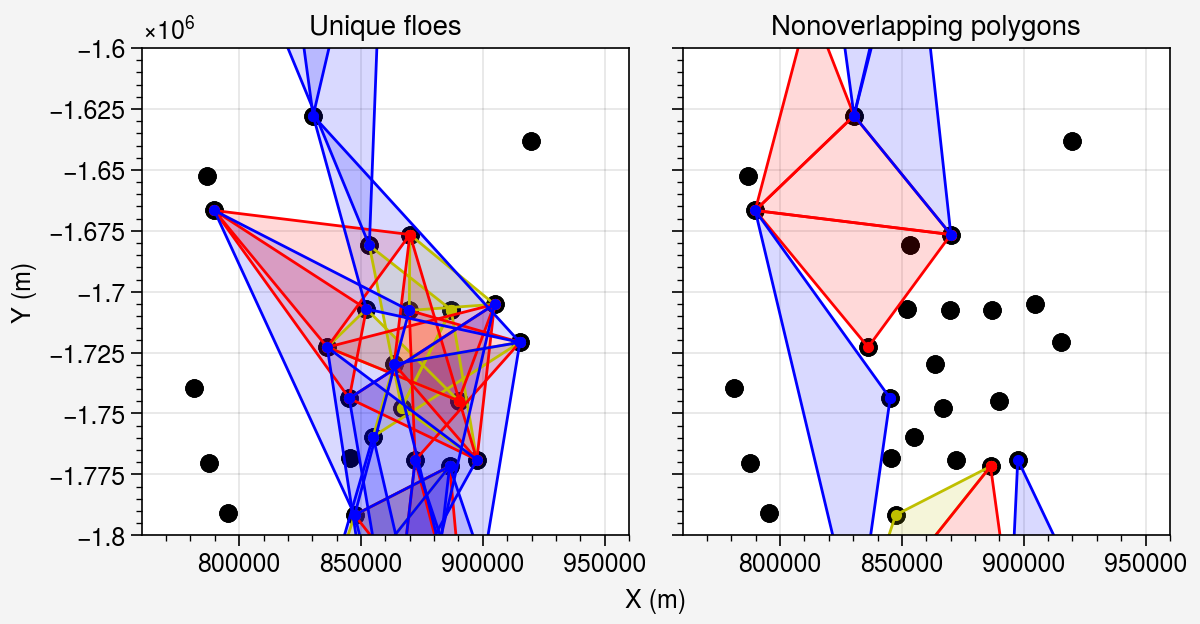

In [4]:
fig, axs = pplt.subplots(width=6, aspect=1, ncols=2)
for ax, sample_type in zip(axs, ['unique_floes_sample', 'no_overlap_sample']):
    for color, lb in zip(['y', 'r', 'b'], [3, 4, 5]):
        df_bin = df_date.loc[df_date.log_bin == lb]
        polygons_init = []
     
        samples = []
        for row, data in df_bin.loc[df_bin[sample_type], :].iterrows():
            samples.append(Polygon([Point(x, y) for x, y in zip([data.x1, data.x2, data.x3],
                                                        [data.y1, data.y2, data.y3])]))
        
        ax.scatter(traj_date.x_stere.values, traj_date.y_stere.values, marker='o', color='k')
        for p in polygons_init:
            ax.plot(*p.exterior.xy, color='k', lw=0.5, marker='', alpha=0.25)
            ax.plot(*p.exterior.xy, color='k', lw=0, marker='.')

        for p in samples:
            ax.plot(*p.exterior.xy, lw=1, zorder=2, alpha=1, c=color, marker='.')
            ax.fill(*p.exterior.xy, lw=0, zorder=2, alpha=0.15, c=color)
        ax.format(ylim=(-1.8e6, -1.6e6), xlim=(0.76e6, 0.96e6))
    axs[0].format(title='Unique floes', xlabel='X (m)', ylabel = 'Y (m)')
    axs[1].format(title='Nonoverlapping polygons')
fig.save('../figures/figS7_unique_v_nonoverlap.png', dpi=300)

/Users/dwatkin2/Documents/research/manuscripts/summer_ice_motion_remote_sensing/miz_scales_of_motion/scripts/11_plot_deformation_polygons.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plot_df.loc[triangle_number, 'x' + str(i)] = float(df_full_date.loc[df_full_date.floe_id == floe_id, 'x_stere'].values)
/Users/dwatkin2/Documents/research/manuscripts/summer_ice_motion_remote_sensing/miz_scales_of_motion/scripts/11_plot_deformation_polygons.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plot_df.loc[triangle_number, 'y' + str(i)] = float(df_full_date.loc[df_full_date.floe_id == floe_id, 'y_stere'].values)
/Users/dwatkin2/Document

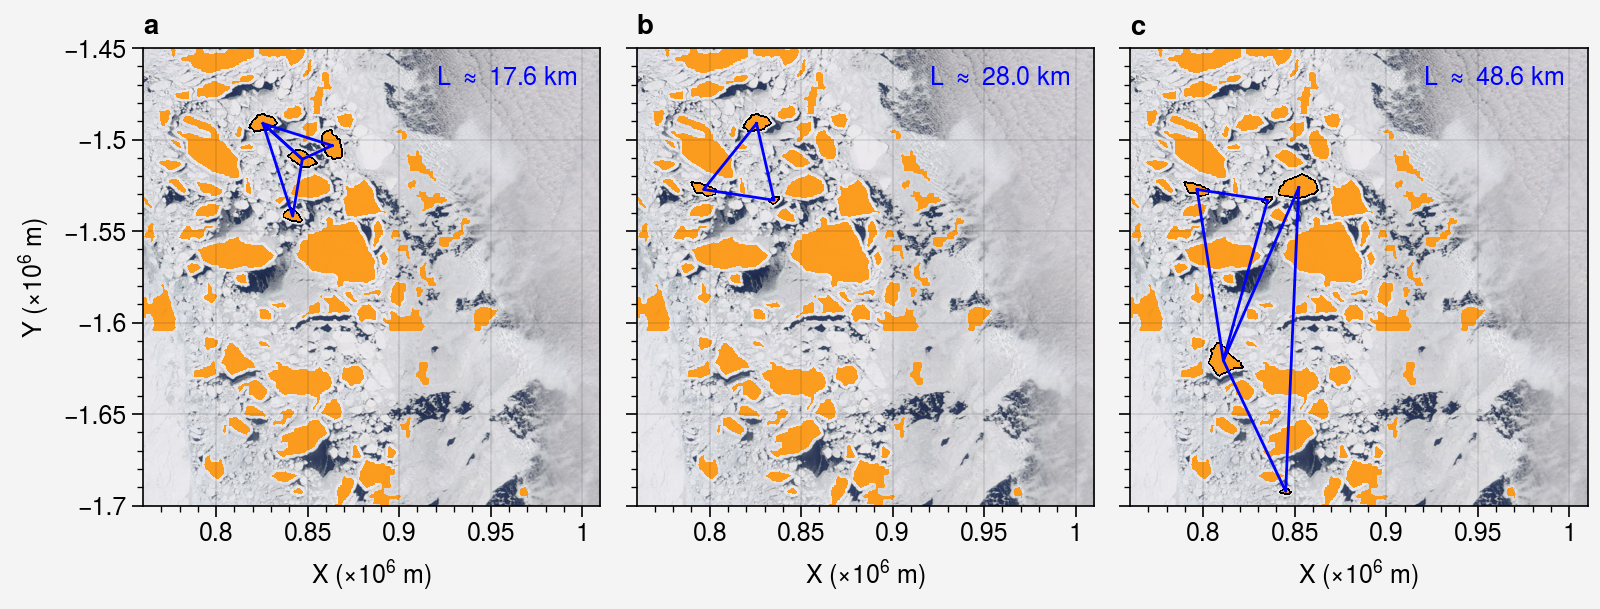

In [15]:
%run ../scripts/11_plot_deformation_polygons.py

In [14]:
date_interp
df_date = df.loc[df.datetime == date_interp]
df_date.groupby('log_bin').count()

datetime  triangle_number  floe1  floe2  floe3  u1  u2  u3  v1  v2  \
log_bin                                                                       
0               3                3      3      3      3   3   3   3   3   3   
1               3                3      3      3      3   3   3   3   3   3   
2               3                3      3      3      3   3   3   3   3   3   
3               2                2      2      2      2   2   2   2   2   2   
4               3                3      3      3      3   3   3   3   3   3   
5               2                2      2      2      2   2   2   2   2   2   
6               1                1      1      1      1   1   1   1   1   1   

         ...  normal_shear  maximum_shear_strain_rate  total_deformation  \
log_bin  ...                                                               
0        ...             3                          3                  3   
1        ...             3                          3                  3   
2        ...             3                          3                  3   
3        ...             2                          2                  2   
4        ...             3                          3                  3   
5        ...             2                          2                  2   
6        ...             1                          1                  1   

         uncertainty_area  uncertainty_divergence  uncertainty_vorticity  \
log_bin                                                                    
0                       3                       3                      3   
1                       3                       3                      3   
2                       3                       3                      3   
3                       2                       2                      2   
4                       3                       3                      3   
5                       2                       2                      2   
6                       1                       1                      1   

         uncertainty_shear  uncertainty_total  no_overlap_sample  \
log_bin                                                            
0                        3                  3                  3   
1                        3                  3                  3   
2                        3                  3                  3   
3                        2                  2                  2   
4                        3                  3                  3   
5                        2                  2                  2   
6                        1                  1                  1   

         unique_floes_sample  
log_bin                       
0                          3  
1                          3  
2                          3  
3                          2  
4                          3  
5                          2  
6                          1  

[7 rows x 45 columns]

## Possibility of non-overlap across scales
* Full dataset is 4,228,491 polygons
* For the scale analysis, we want to have polygons that don't overlap. The idea here is that if the polygons overlap, that may result in statistical correlations between polygons at different length scales.
* Sufficient polygons exist to draw a subset for each month for the scaling analysis

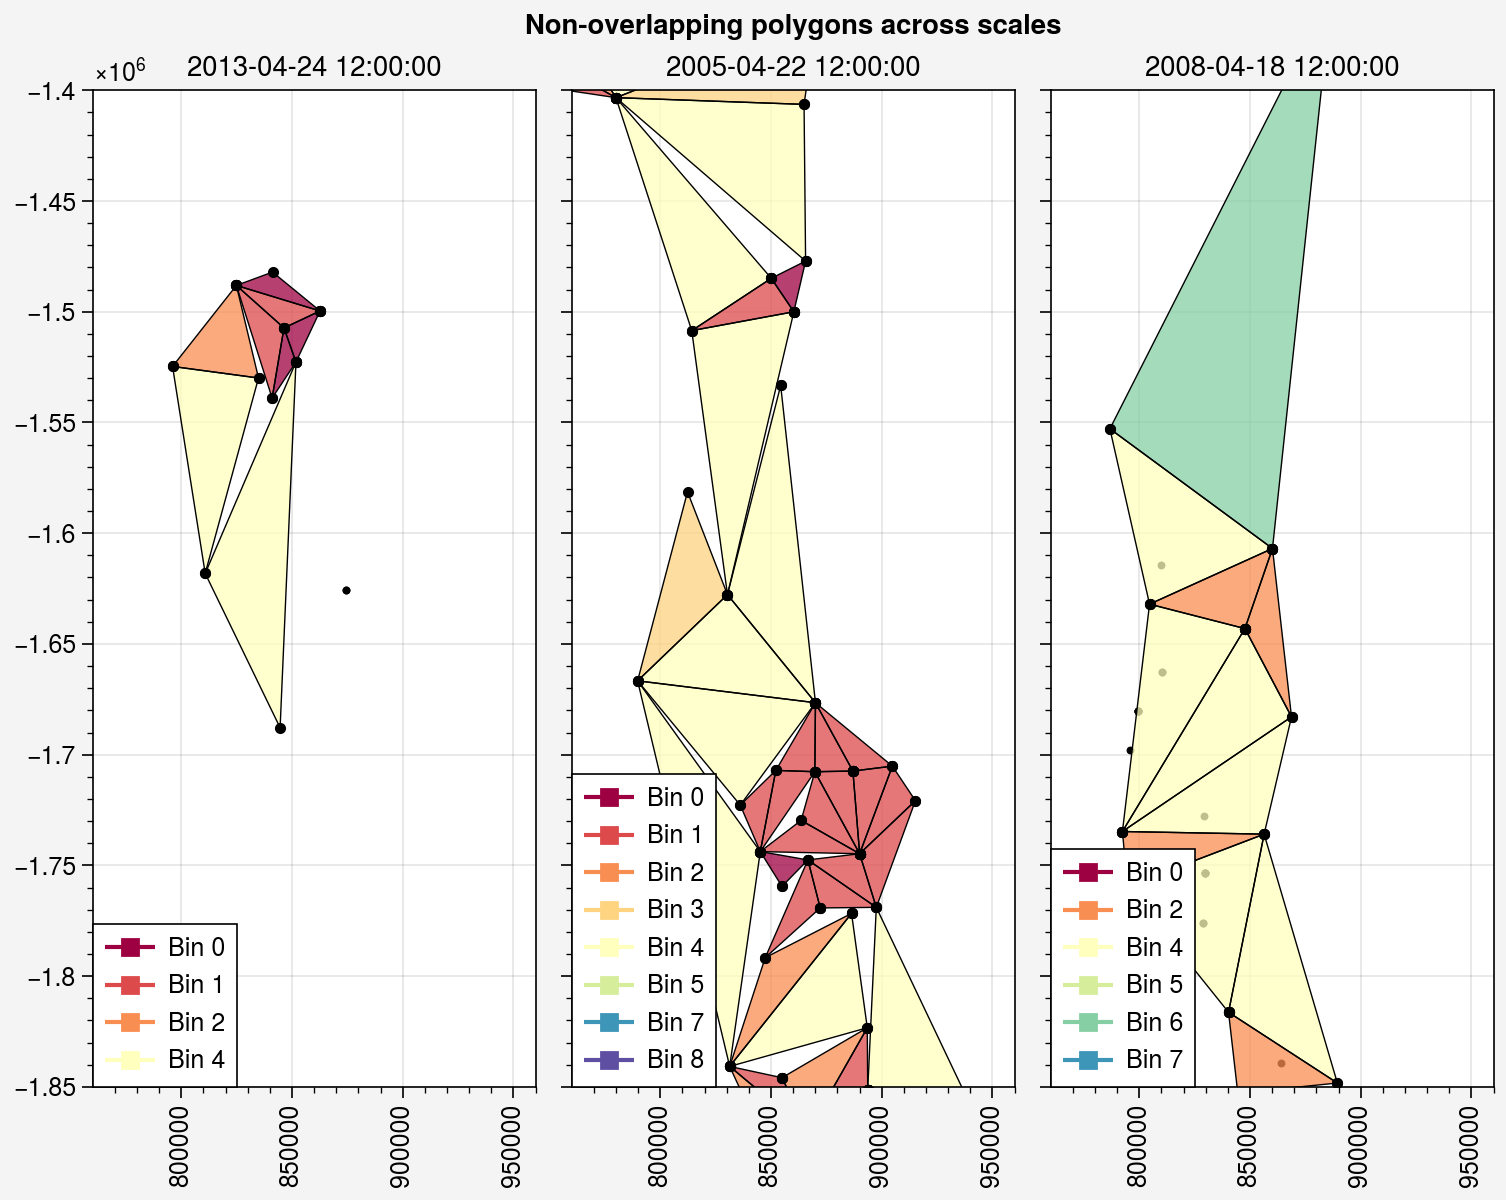

In [13]:
fig, axs = pplt.subplots(height=6, aspect=1, ncols=3)
dates = [date_interp, '2005-04-22 12:00:00', '2008-04-18 12:00:00', '2020-04-22 12:00:00']
colors = [c['color'] for c in pplt.Cycle('spectral', 9)]
colors = {b: c for b, c in zip(np.arange(9), colors)}

for ax, date in zip(axs, dates):
    df_date = df.loc[df.datetime == date]
    # All points
    ax.scatter(df_date.x1.values, df_date.y1.values, color='k', ms=5)
    # print(df_date.loc[df_date.no_overlap_sample].groupby('log_bin').count()['u1'])
    bins = df_date.loc[df_date.no_overlap_sample].log_bin.unique()
    bins = list(bins)
    bins.sort()
    
    h, l = [], []
    for bin_number in bins:
        c = colors[bin_number]
        df_bin = df_date.loc[(df_date.log_bin == bin_number) & df_date.no_overlap_sample]
        polygons_init = []
        for row, data in df_bin.iterrows():
            polygons_init.append(Polygon([Point(x, y) for x, y in zip([data.x1, data.x2, data.x3],
                                                        [data.y1, data.y2, data.y3])]))
        for p in polygons_init:
            ax.plot(*p.exterior.xy, color='k', lw=0.5, marker='', alpha=1)
            ax.plot(*p.exterior.xy, color='k', lw=0, marker='.')
            ax.fill(*p.exterior.xy, lw=0, zorder=2, alpha=0.75, c=c)
    
        h.append(ax.plot([],[], marker='s', color=c))
        l.append('Bin ' + str(bin_number))
    ax.legend(h, l, loc='ll', ncol=1, alpha=1)
    ax.format(title=date)
        
    ax.format(ylim=(-1.85e6, -1.4e6), xlim=(0.76e6, 0.96e6), xrotation=90, suptitle='Non-overlapping polygons across scales')
fig.save('../figures/figS8_nonoverlap_across_scales.png', dpi=300)

# Deformation uncertainty

The uncertainty in deformation depends on the uncertainty in velocity, position, time, and area, while the uncertainty in area depends on the position uncertainty and the shape of the triangle. We examine the uncertainty theoretically first, then look at the variation in uncertainty in the dataset.

## Uncertainty variation with triangle skewness
We estimate the uncertainty in a triangle, using the formula from Dierking et al. (2020):

$$\delta_A^2 = \frac{\delta_x^2}{4}(a^2 + b^2 + c^2)$$


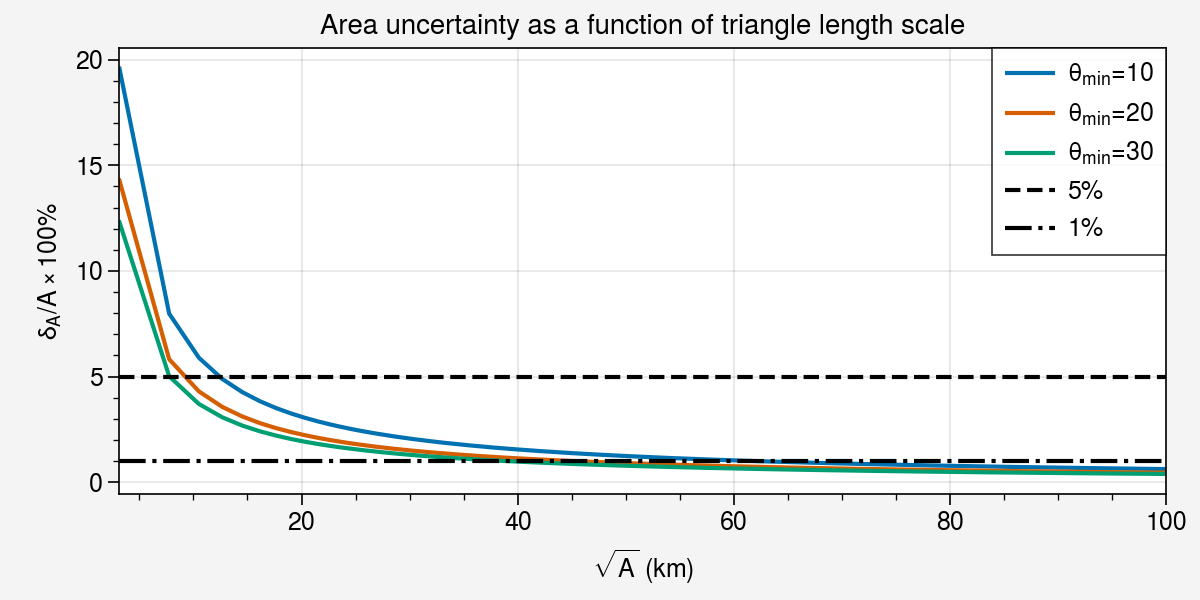

In [133]:
# Uncertainty as a function of shape for right triangles
tri_a = np.linspace(10, 100**2, 200)*1e6
def triangle_area_error(A, minimum_angle, delta_x=255):
    a = np.sqrt(2*A/np.tan(np.deg2rad(minimum_angle)))
    b = a*np.tan(np.deg2rad(minimum_angle))
    c = np.sqrt(a**2 + b**2)
    rel_a = np.sqrt(256**2/4*(a**2 + b**2 + c**2))/A
    return rel_a
    
fig, ax = pplt.subplots(width=6, height=3)
ax.plot(np.sqrt(tri_a/1e6), triangle_area_error(tri_a, 10) * 100, label='$\\theta_{\\min}$=10')
ax.plot(np.sqrt(tri_a/1e6), triangle_area_error(tri_a, 20) * 100, label='$\\theta_{\\min}$=20')
ax.plot(np.sqrt(tri_a/1e6), triangle_area_error(tri_a, 30) * 100, label='$\\theta_{\\min}$=30')

ax.axhline(5, color='k', ls='--', label='5%')
ax.axhline(1, color='k', ls='-.', label='1%')

ax.legend(ncols=1)
ax.format(ylabel='$\delta_A/A \\times 100\%$', xlabel='$\sqrt{A}$ (km)', title='Area uncertainty as a function of triangle length scale')

What we see is that there is a larger improvement in uncertainty with the shift from 10 degree minimum to 20 degree minimum interior angle. Hence, in this analysis we use 20 degrees as the minimum interior angle.

## Uncertainty contributions from time, speed, and area
Next, we look at the relative uncertainty calculation from Hutchings et al. 2012.

$$\frac{\delta_\epsilon}{\epsilon} = 2\left(4 \frac{\delta_x^2}{A} + 2 \frac{\delta_x^2}{U^2T^2} + \frac{\delta_T^2}{T^2} + \frac{\delta_A^2}{A^2}\right)^{1/2}$$

The question here is what effect the minimum area has on the uncertainty as a function of mean velocity. Since the uncertainty in area is reduced as the minimum angle increases, we'll use minimum angle = 20. The uncertainty in time for the IFT product is unknown, as we have high precision when we are in the middle of an image, but the composite images have ambiguous times. So we'll look at sensitivity to time, area, and velocity.

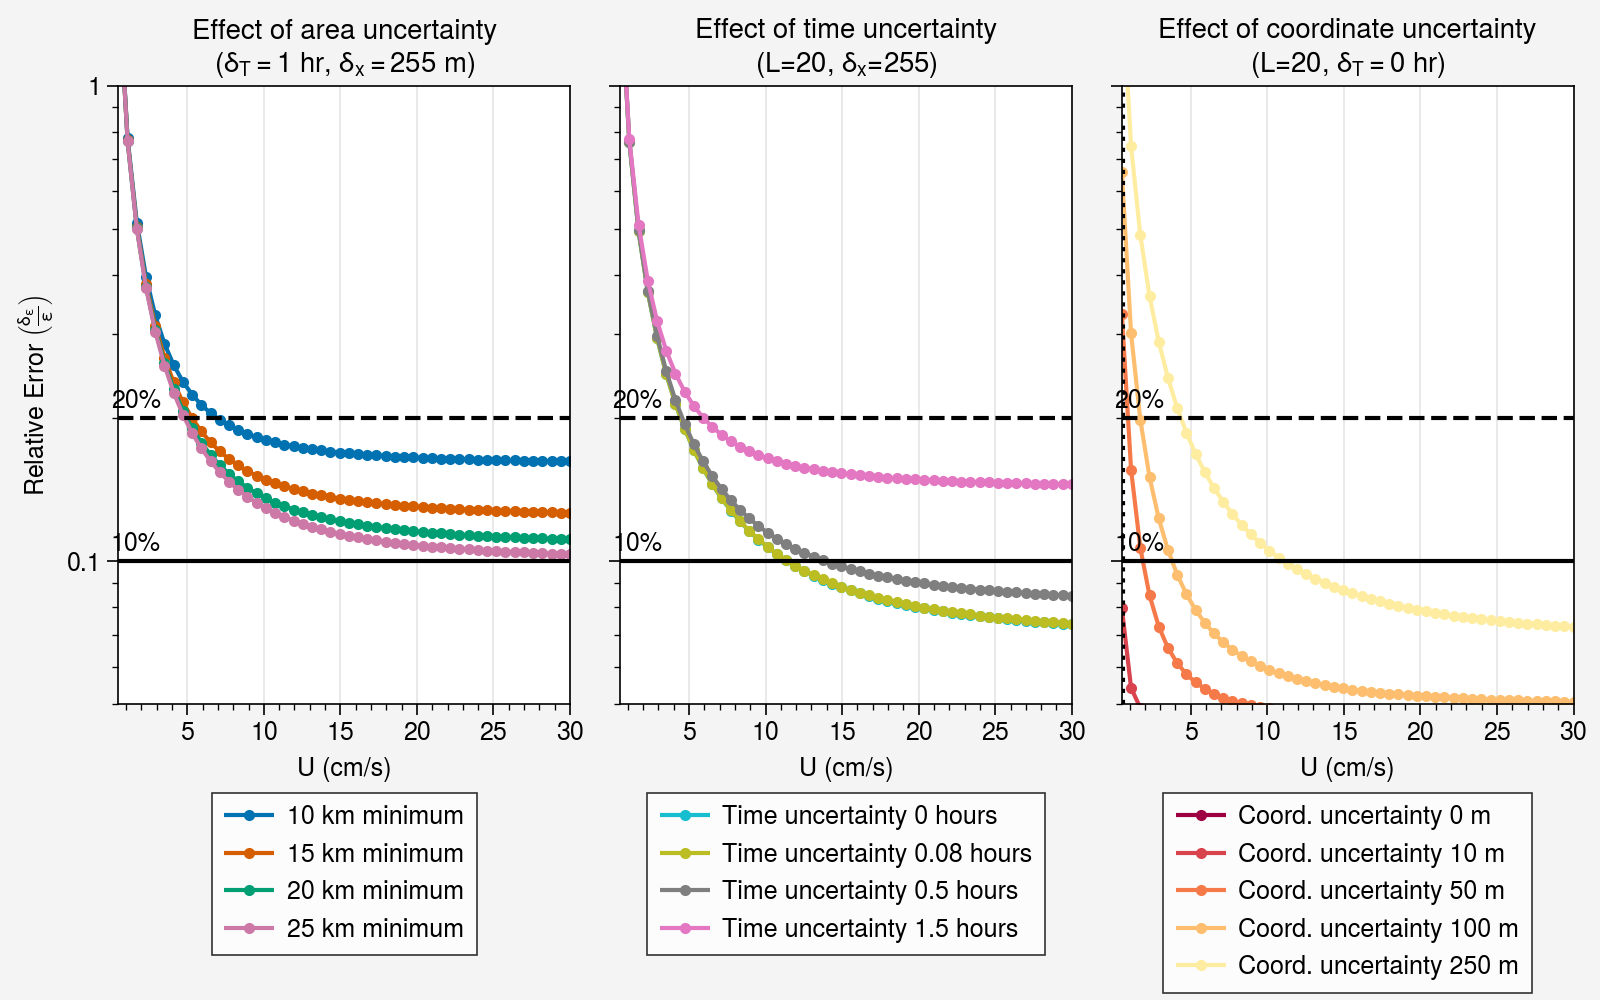

In [134]:
T = 24 # hours
delta_T = 1 # hour
delta_x = 255 # meters
U = np.linspace(0.005, 0.3) # meters per second

def rel_error_strain(A, U, T, delta_x, delta_T, delta_A):
    return 2*(4*delta_x**2 / A + 2*delta_x**2 / (U**2 * (T * 60 * 60)**2) + \
              (delta_T/T)**2 + (delta_A/A)**2)**0.5
fig, axs = pplt.subplots(width=8, height=5, ncols=3, sharex=False)
ax = axs[0]
for L in [10, 15, 20, 25]:
    A = (L * 1e3)**2
    delta_A = triangle_area_error(A, minimum_angle=20, delta_x=256)*A
    ax.plot(U*100, rel_error_strain(A, U, T, delta_x, delta_T, delta_A), marker='.', label='{l} km minimum'.format(l=L))
ax.axhline(0.2, ls='--', color='k')
ax.axhline(0.1, ls='-', color='k')
ax.text(0.01, 0.21, '20%')
ax.text(0.01, 0.105, '10%')

ax.format(ylabel='$\\frac{\\delta_\\epsilon}{\\epsilon}$', xlabel='U (cm/s)')
ax.legend(ncols=1, loc='b')
ax.format(yscale='log', ylim=(0.05, 1), title='Effect of area uncertainty\n($\delta_T = 1$ hr, $\delta_x=255$ m)')

L = 20
ax = axs[1]
for delta_T in [0, 5/60, 0.5, 1.5]:
    A = (L * 1e3)**2
    delta_A = triangle_area_error(A, minimum_angle=20, delta_x=256)*A
    ax.plot(U*100, rel_error_strain(A, U, T, delta_x, delta_T, delta_A),
            marker='.', label='Time uncertainty {t} hours'.format(t=np.round(delta_T, 2)), cycle='tab10_r')
ax.axhline(0.2, ls='--', color='k')
ax.axhline(0.1, ls='-', color='k')
ax.text(0.01, 0.21, '20%')
ax.text(0.01, 0.105, '10%')

ax.format(ylabel='Relative Error $\\left(\\frac{\\delta_\\epsilon}{\\epsilon}\\right)$',
          xlabel='U (cm/s)')
ax.legend(ncols=1, loc='b')
ax.format(yscale='log', ylim=(0.05, 1),
          title='Effect of time uncertainty\n(L=20, $\delta_x$=255)')

L = 20
delta_T = 0
ax = axs[2]
for delta_x in [0, 10, 50, 100, 250]:
    A = (L * 1e3)**2
    delta_A = triangle_area_error(A, minimum_angle=20, delta_x=delta_x)*A
    ax.plot(U * 100, rel_error_strain(A, U, T, delta_x, delta_T, delta_A),
            marker='.', label='Coord. uncertainty {x} m'.format(x=np.round(delta_x, 2)), cycle='spectral')
ax.axhline(0.2, ls='--', color='k')
ax.axhline(0.1, ls='-', color='k')
ax.axvline(2*255*100/(24*60*60), color='k', ls=':')
ax.text(0.01, 0.21, '20%')
ax.text(0.01, 0.105, '10%')

ax.format(ylabel='Relative Error $\\left(\\frac{\\delta_\\epsilon}{\\epsilon}\\right)$', xlabel='U (cm/s)')
ax.legend(ncols=1, loc='b')
ax.format(yscale='log', ylim=(0.05, 1), title='Effect of coordinate uncertainty\n(L=20, $\delta_T=0$ hr)')
fig.save('../figures/figS9_uncertainty_analysis.png', dpi=300)

The uncertainty in the total deformation is sensitive both to the velocity and to the uncertainty in time. On the left, we look at sensitivity to the triangle area for a right triangle with 20 degree minimum interior angle, with time error held fixed at 1 hour. We see a big jump in the relative error going from 10 km minimum to 15 km. Similarly, we see that varying the time uncertainty from 0 to 90 minutes results in a large change in the relative error. However for drift speeds larger than 5 cm/s, even with time uncertainty of 1 hour, we see relative uncertainties less than 20 percent. 

In order to improve the uncertainty for low velocities, it is necessary to improve the coordinate error. Estimates of the floe centroid are used for the floe position, and based on the analysis of Lopez-Acosta et al. 2019, the position uncertainty is essentially 1 pixel -- 255 m. This value was determined based on the comparison between manually labeled and automatically labeled ice floes. Theoretically, the precision should depend on the floe size -- the centroid is a statistical measure and can have sub-grid accuracy. So the coordinate uncertainty could potentially be reduced to close to the geolocation error for MODIS (around 150 m).

In [36]:
df['relative_error'] = df['uncertainty_total']/df['total_deformation']
df['Umean'] = np.sqrt(df.loc[:, ['u1', 'u2', 'u3']]**2).mean(axis=1) * 100


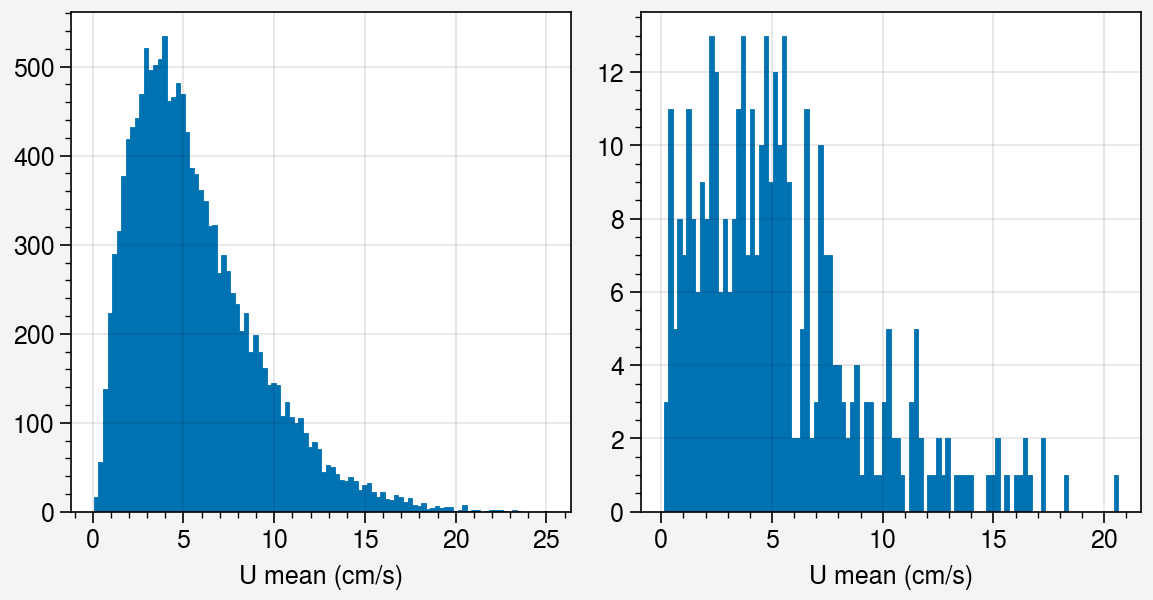

In [39]:
fig, ax = pplt.subplots(ncols=2, share=False)
_ = ax[0].hist(df.loc[(df.relative_error <= 1) & df.no_overlap_sample, 'Umean'], bins=100)
_ = ax[1].hist(df.loc[(df.relative_error > 1) & df.no_overlap_sample, 'Umean'], bins=100)
ax[0].format(xscale='linear', yscale='linear', xlabel='U mean (cm/s)')
ax[1].format(xscale='linear', yscale='linear', xlabel='U mean (cm/s)')

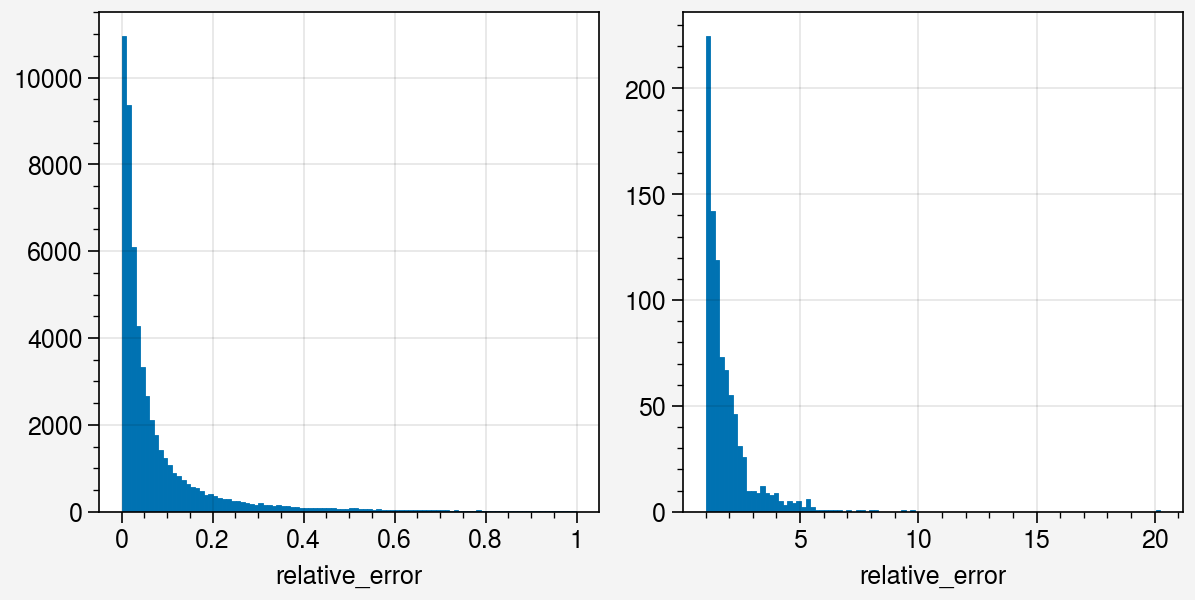

In [27]:
fig, ax = pplt.subplots(ncols=2, share=False)
_ = ax[0].hist(df.loc[df.relative_error <= 1, 'relative_error'], bins=100)
_ = ax[1].hist(df.loc[df.relative_error > 1, 'relative_error'], bins=100)
ax[1].format(xscale='linear', yscale='linear')

In [215]:
df.loc[df.relative_error <= 0.5, ['log_bin', 'L', 'relative_error', 'total_deformation']].groupby('log_bin').mean()

L  relative_error  total_deformation
log_bin                                               
0         12.646711        0.207996       6.383838e-06
1         18.361306        0.163456       4.350649e-06
2         25.390739        0.116382       3.412928e-06
3         35.207344        0.079137       2.754704e-06
4         48.874703        0.051554       2.158055e-06
5         67.478732        0.033109       1.718207e-06
6         93.190187        0.021334       1.336531e-06
7        127.150806        0.014166       1.052197e-06
8        173.962671        0.009119       8.228889e-07
9        234.568202        0.006158       6.652537e-07
10       316.206001        0.004149       5.389565e-07

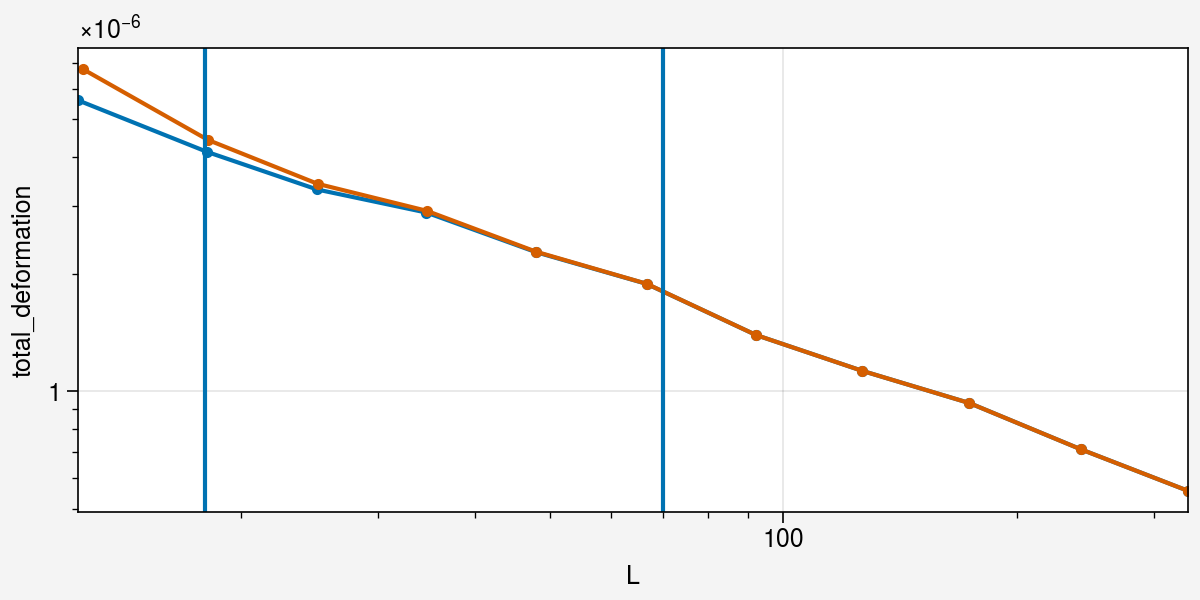

In [34]:
fig, ax = pplt.subplots(width=6, height=3)
ax.plot(x='L', y='total_deformation',
        data=df.loc[(df.relative_error <= 1) & df.no_overlap_sample,
            ['log_bin', 'L', 'total_deformation']].groupby('log_bin').mean()[['L', 'total_deformation']],
marker='.')

ax.plot(x='L', y='total_deformation',
        data=df.loc[(df.relative_error <= 0.5) & df.no_overlap_sample,
            ['log_bin', 'L', 'total_deformation']].groupby('log_bin').mean()[['L', 'total_deformation']],
       marker='.', label='Only small error')
ax.format(yscale='log', xscale='log')
ax.axvline(18)
ax.axvline(70)

In [33]:
df['month'] = df.datetime.dt.month
df.loc[df.no_overlap_sample,:].groupby(['log_bin', 'month']).count().pivot_table(index='month', values='u1', columns='log_bin').fillna(0)

log_bin     0       1       2      3      4      5      6      7     8     9   \
month                                                                           
4        549.0   588.0   813.0  853.0  847.0  468.0  295.0  178.0  81.0  18.0   
5        708.0  1000.0  1000.0  997.0  672.0  461.0  276.0  160.0  53.0  23.0   
6        370.0   606.0   985.0  933.0  837.0  542.0  346.0  155.0  74.0  20.0   

log_bin   10  
month         
4        4.0  
5        6.0  
6        3.0

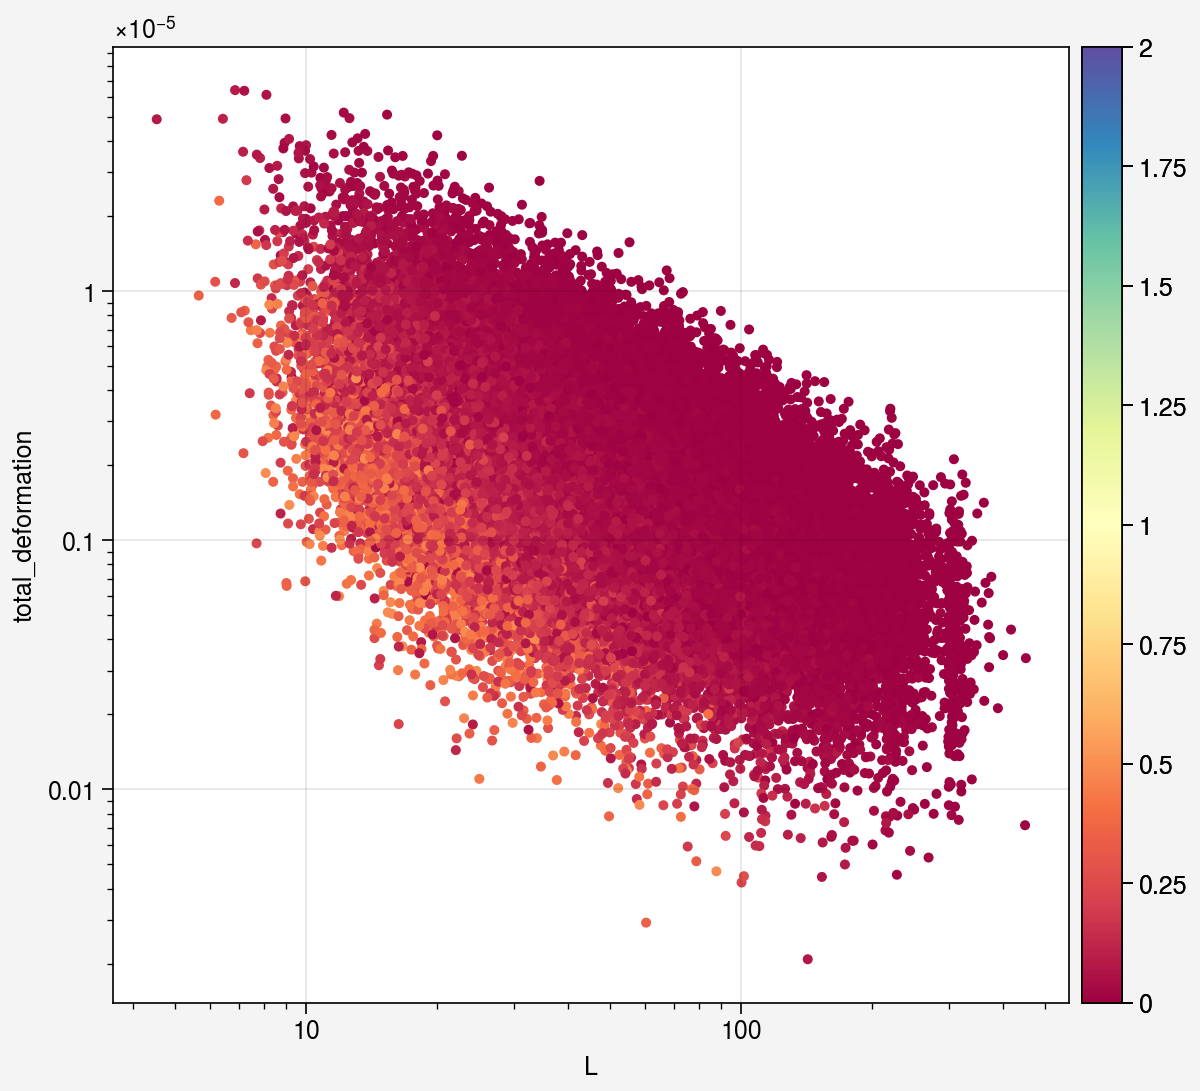

In [241]:
fig, ax = pplt.subplots(width=6)
ax.scatter(df.loc[df.relative_error < 0.5, 'L'],
           df.loc[df.relative_error < 0.5, 'total_deformation'], m='.',
           c=df.loc[df.relative_error < 0.5, 'relative_error'], vmin=0, vmax=2, cmap='spectral', colorbar='r')
ax.format(yscale='log', xscale='log')

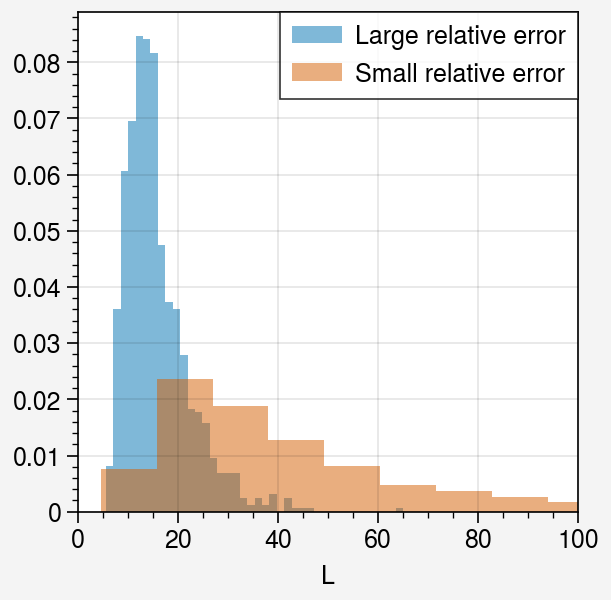

In [252]:
df = pd.read_csv('../data/deformation/sampled_results.csv')
df['Umean'] = np.sqrt(df.loc[:, ['u1', 'u2', 'u3']]**2).mean(axis=1) * 100
df['relative_error'] = df['uncertainty_total'] / df['total_deformation']

fig, ax = pplt.subplots()
_ = ax.hist(df.loc[df.no_overlap_sample & (df.relative_error >= 0.5), 'L'],
        bins=40, alpha=0.5, label='Large relative error', density=True)

_ = ax.hist(df.loc[df.no_overlap_sample & (df.relative_error < 0.5), 'L'],
        bins=40, alpha=0.5, label='Small relative error', density=True)
# ax.format(xlabel='Polygon mean drift speed (cm/s)')
ax.format(xlim=(0, 100))
ax.legend(ncols=1)

In [127]:
df.loc[df.no_overlap_sample].Umean.median()

4.877

In [142]:
all_results['Umean'] = np.sqrt(all_results[['u1', 'u2', 'u3']]**2).mean(axis=1)

In [178]:
# all_results.loc[all_results['Umean'] > 0.05].shape
logbins = np.logspace(np.log(15), np.log(300), base=np.e, num=10)
logbins

array([ 15.        ,  20.92426191,  29.18831576,  40.71626425,
        56.79718514,  79.22927851, 110.52094496, 154.17127992,
       215.06134933, 300.        ])

# Visualization of the scale analysis
1. Standard method: average within bins. Weighted curve fit. Need to make sure that the figure is plotted correctly: do we indeed see the best fit line aligning with the bin means? If not, there's an error in the math.

In [ ]:
%run ../scripts/12_bootstrap_analysis_scaling.py

Filtering by relative error reduced number of samples from  51634 to 50484


/Users/dwatkin2/Documents/research/manuscripts/summer_ice_motion_remote_sensing/miz_scales_of_motion/scripts/13_plot_deformation_scaling.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  SE = data.groupby('log_bin').apply(lambda x: stats.sem(x['total_deformation']))
/Users/dwatkin2/Documents/research/manuscripts/summer_ice_motion_remote_sensing/miz_scales_of_motion/scripts/13_plot_deformation_scaling.py:55: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns a

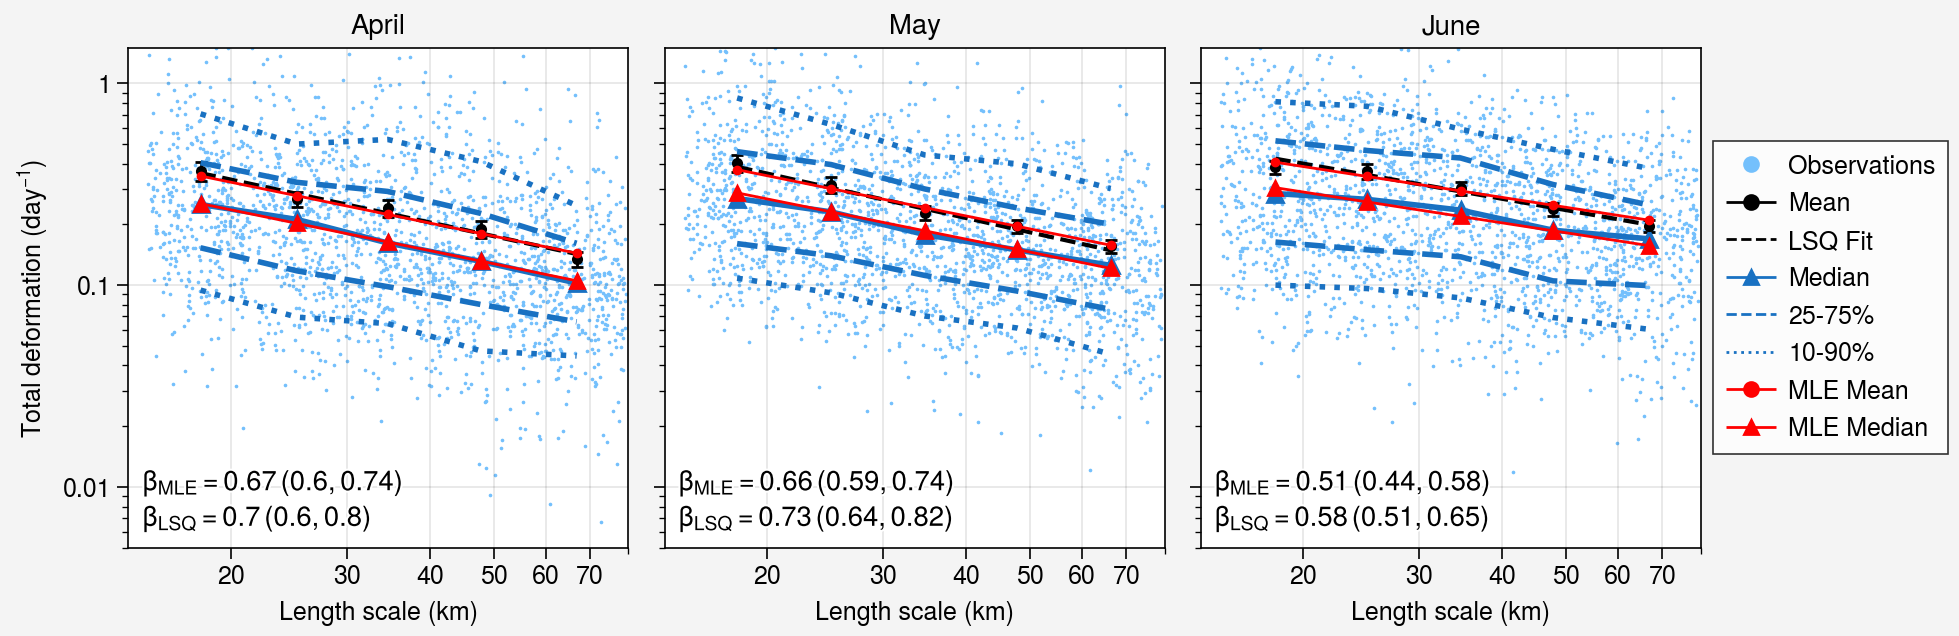

In [40]:
%run ../scripts/13_plot_deformation_scaling.py

## The change in deformation slope indicates increased deformation at larger scales

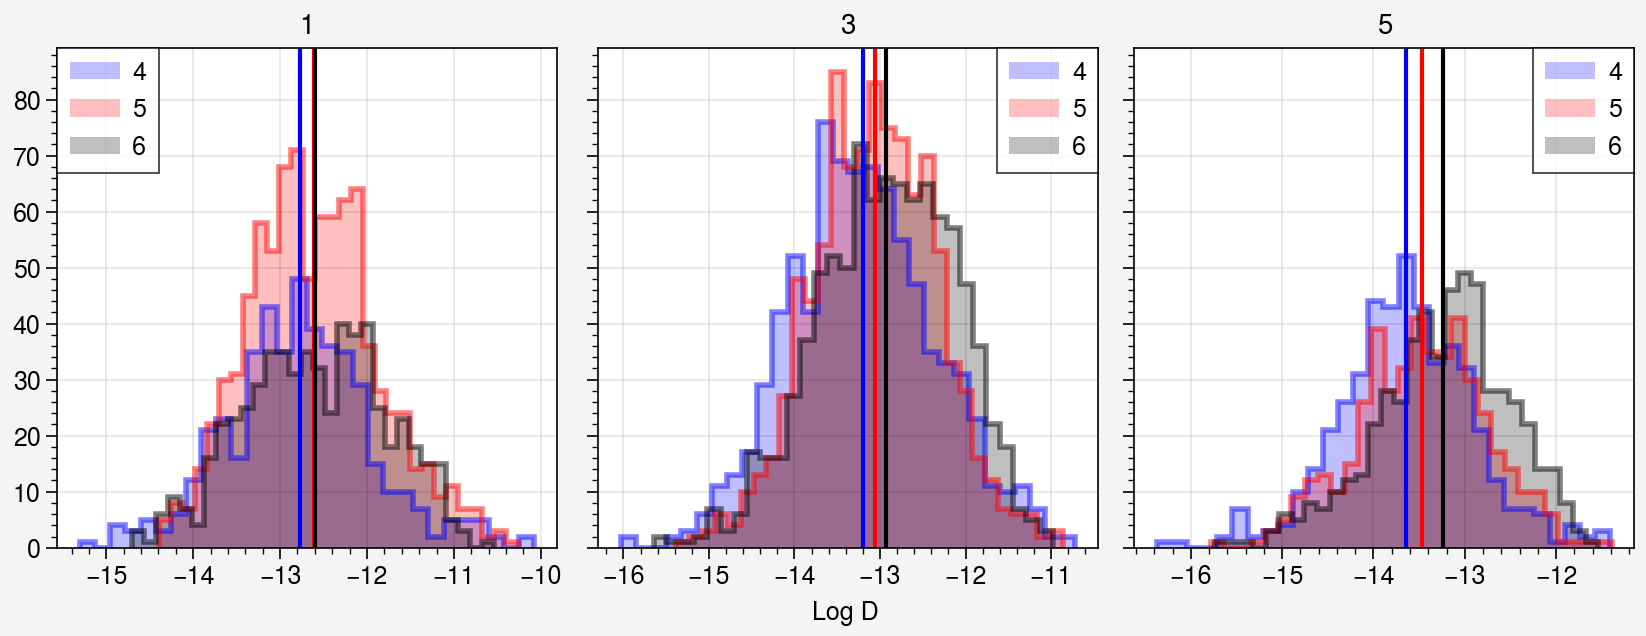

In [62]:

fig, axs = pplt.subplots(ncols=3)
for ax, log_bin in zip(axs, [1, 3, 5]):
    for c, month in zip(['b', 'r', 'k'], [4, 5, 6]):
        idx = df.log_bin == log_bin
        idx = idx & (df.month == month)
        idx = idx & df.no_overlap_sample
        idx = idx & (df.relative_error < 0.5)
        ax.hist(np.log(df.loc[idx, 'total_deformation']), label='', alpha=0.5, bins=30, histtype='step', lw=2, color=c)
        ax.hist(np.log(df.loc[idx, 'total_deformation']), label=month, alpha=0.25, bins=30, lw=2, color=c)
        ax.axvline(np.mean(np.log(df.loc[idx, 'total_deformation'])), c=c)
        ax.legend(ncols=1)
        ax.format(title=log_bin, xlabel='Log D')
        

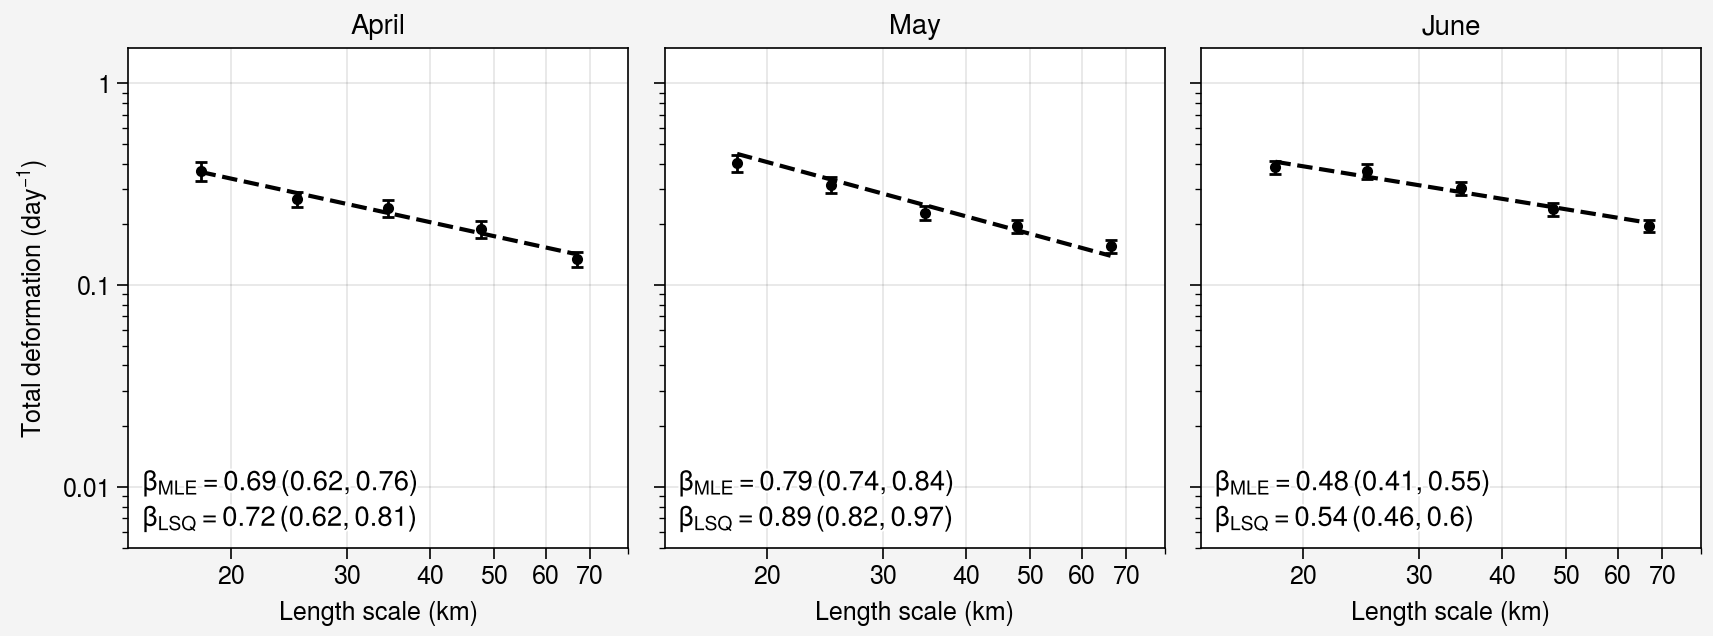

In [278]:
fig, axs = pplt.subplots(ncols=3, sharex=False)
for ax, month, monthname in zip(axs, range(4, 7), ['April', 'May', 'June']):
    strat_samp = samples[month].loc[samples[month].log_bin.between(1, 5)]
    data = strat_samp.loc[(strat_samp.datetime.dt.month == month) & (strat_samp.no_overlap_sample)]
    # ax.scatter(data['L'].values, data['total_deformation'].values*24*60*60, m='.', color='blue3', ms=2, zorder=0, label='')
    
    data_mean = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
    data_std = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').std()
    # compute the standard error of the mean
    n = 400
    dist = stats.t(n-1)
    critical_value = dist.ppf(0.975)
    SE = data.groupby('log_bin').apply(lambda x: stats.sem(x['total_deformation']))
    ax.errorbar(
        data_mean['L'].values, data_mean['total_deformation'].values*24*60*60,
        yerr=critical_value * SE.values*24*60*60,
        marker='.', color='k', lw=0, elinewidth=1, capsize=2)    

    n = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').count()    
    beta_mle = bs_table.loc[month, 'beta_mle']
    scaled_eps = data['total_deformation']*(60*60*24)*data['L']**beta_mle
    mu = np.mean(np.log(scaled_eps))
    sigma = np.std(np.log(scaled_eps))
    mean = np.exp(mu + sigma**2/2)
    stdev = np.sqrt((np.exp(sigma**2)-1)*np.exp(2*mu + sigma**2))
    
    # # Log-normal estimate of the median
    # L = data_mean['L'].values
    # ax.plot(L, np.exp(mu)*L**(-beta_mle), label='', color='r', marker='^', ms=5, lw=1, zorder=5)

    # # Log-normal estimate of the mean
    # ax.plot(L, mean*L**(-beta_mle), label='', color='r', marker='.', ms=5, lw=1, zorder=5)

    # LSQ slope
    beta_lsq = bs_table.loc[month, 'beta_lsq']
    int_lsq = bs_table.loc[month, 'a_lsq'] # already has had exponent applied
    ax.plot(data_mean['L'].values, int_lsq*data_mean['L'].values**(-beta_lsq), label='', color='k', ls='--')

    # df_quantiles = pd.DataFrame({q: strat_samp[['log_bin', 'total_deformation']].groupby('log_bin').quantile(q).values.squeeze()
    #                              for q in [0.1, 0.25, 0.5, .75, 0.9]},
    #                             index = strat_samp[['log_bin', 'L']].groupby('log_bin').mean().values.squeeze())

    # for q, ls in zip([0.1, 0.25, 0.5, .75, 0.9], [':', '--', '-', '--', ':']):
    #     if q == 0.5:
    #         m = '^'
    #     else:
    #         m = ''
    #     ax.plot(df_quantiles.index, df_quantiles[q].values*24*60*60, color='blue8', ls=ls, lw=2, m=m)

    min_beta = bs_table.loc[month, 'min_beta_mle']
    max_beta = bs_table.loc[month, 'max_beta_mle']    
    mle_result = '$\\beta_{m}={b} \, ({minb}, {maxb})$'.format(b=np.round(beta_mle, 2),
                                                              minb=np.round(min_beta, 2),
                                                              maxb=np.round(max_beta, 2),
                                                               m="{MLE}")
    beta_lsq = bs_table.loc[month, 'beta_lsq']
    min_beta = bs_table.loc[month, 'min_beta_lsq']
    max_beta = bs_table.loc[month, 'max_beta_lsq']    
    lsq_result = '$\\beta_{m}={b} \, ({minb}, {maxb})$'.format(b=np.round(beta_lsq, 2),
                                                              minb=np.round(min_beta, 2),
                                                              maxb=np.round(max_beta, 2),
                                                               m="{LSQ}")

    # add lsq result text
    ax.format(lltitle=mle_result + '\n' + lsq_result)
    ax.format(yscale='log', xscale='log', ylim=(0.005, 1.5), xlabel='Length scale (km)',
              ylabel='Total deformation (day$^{-1}$)', xlim=(14, 80), title=monthname, xreverse=False)

    h = [ax.plot([],[], c=c, lw=lw, m=m, ms=ms, ls=ls) for c, lw, m, ms, ls in zip(
                    ['blue3', 'k', 'blue8', 'blue8', 'blue8', 'r', 'r'],
                    [0, 1, 1, 1, 1, 1, 1],
                    ['o', 'o', '^', '', '', 'o', '^'],
                    [5, 5, 5, 0, 0, 5, 5],
                    ['', '-', '-', '--', ':', '-', '-'])]

    ax.format(yscale='log', xscale='log', xlocator=[20, 30, 40, 50, 60, 70])



If the data are log-normally distributed, 

In [337]:
%%time
%run ../scripts/12_bootstrap_analysis_scaling.py

CPU times: user 2min 6s, sys: 339 ms, total: 2min 6s
Wall time: 2min 6s


In [279]:
from scipy.stats import linregress

In [316]:
data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()

L  total_deformation
log_bin                              
1        18.027180           0.000005
2        25.014029           0.000004
3        34.671102           0.000003
4        47.791974           0.000002
5        66.277806           0.000002

In [319]:
bs_table = pd.read_csv('../data/deformation/scaling_estimates.csv', index_col='month')
bs_table

min_beta_mle  max_beta_mle  min_beta_lsq  max_beta_lsq  beta_mle  \
month                                                                     
4          0.616935      0.756231      0.619839      0.812042  0.686583   
5          0.611960      0.746281      0.656729      0.824146  0.676633   
6          0.407990      0.547286      0.464027      0.602410  0.482613   

       beta_lsq     a_lsq  
month                      
4      0.716190  2.882199  
5      0.741326  3.389585  
6      0.535350  1.928861

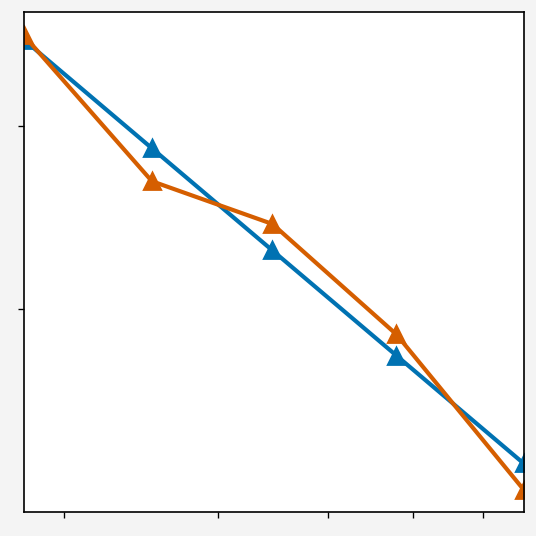

In [324]:
month = 4
strat_samp = samples[month].loc[samples[month].log_bin.between(1, 5)]
data = strat_samp.loc[(strat_samp.datetime.dt.month == month) & (strat_samp.no_overlap_sample)]
data_mean = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
# compute the standard error of the mean
n = 400
dist = stats.t(n-1)
critical_value = dist.ppf(0.975)
SE = data.groupby('log_bin').apply(lambda x: stats.sem(x['total_deformation']))

beta_lsq = bs_table.loc[month, 'beta_lsq']
int_lsq = bs_table.loc[month, 'a_lsq']

fig, ax = pplt.subplots()
ax.plot(data_mean['L'].values, int_lsq*data_mean['L'].values**(-beta_lsq), marker='^')
ax.plot(data_mean['L'].values, data_mean['total_deformation'].values*24*60*60, marker='^')
ax.format(yscale='log', xscale='log')

4 [66.76923753  0.13418933]
5 [66.27780565  0.15538811]
6 [66.82247489  0.1971779 ]


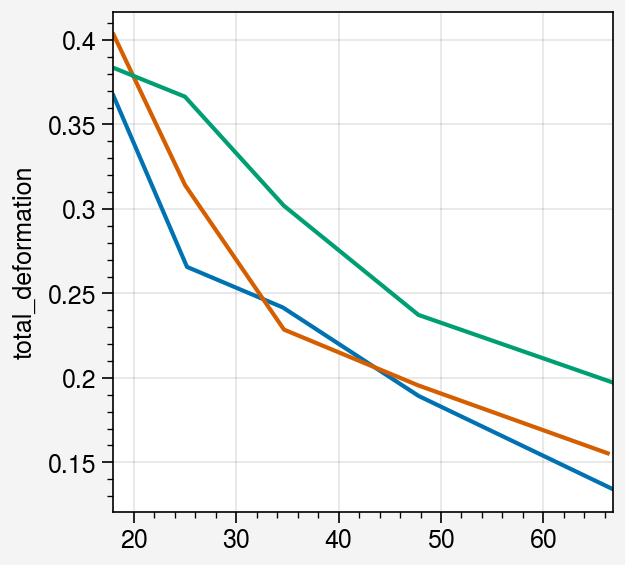

In [331]:
fig, ax = pplt.subplots()
for month in samples:
    strat_samp = samples[month].loc[samples[month].log_bin.between(1, 5)]
    data = strat_samp.loc[(strat_samp.datetime.dt.month == month) & (strat_samp.no_overlap_sample)]
    data_mean = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
    data_mean['total_deformation'] *= 24*60*60
    ax.plot(data_mean['L'].values, data_mean['total_deformation'])
    print(month, data_mean.iloc[4,:].values)

4 [65.87174862  0.10235321]
5 [65.36026697  0.12526517]
6 [65.98795072  0.16951235]


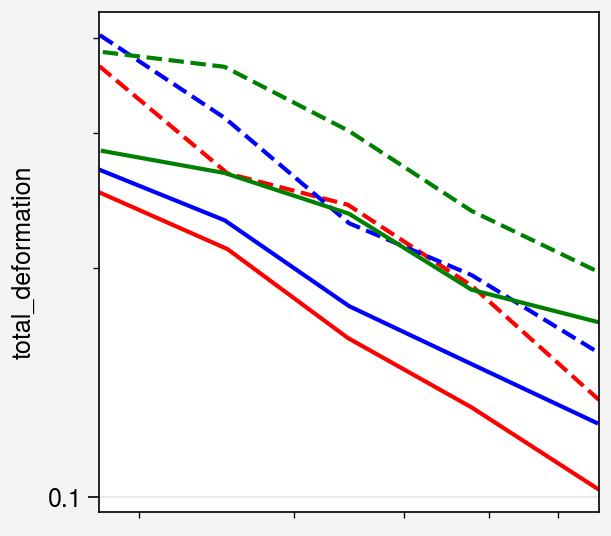

In [336]:
fig, ax = pplt.subplots()
for c, month in zip(['r', 'b', 'g'], samples):
    strat_samp = samples[month].loc[samples[month].log_bin.between(1, 5)]
    data = strat_samp.loc[(strat_samp.datetime.dt.month == month) & (strat_samp.no_overlap_sample)]
    data_mean = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
    data_mean['total_deformation'] *= 24*60*60
    data_median = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').median()
    data_median['total_deformation'] *= 24*60*60
    ax.plot(data_mean['L'].values, data_mean['total_deformation'], ls='--', c=c)
    ax.plot(data_mean['L'].values, data_median['total_deformation'], ls='-',c=c)
    print(month, data_median.iloc[4,:].values)
    ax.format(yscale='log', xscale='log')

(array([ 30.,  68.,  98., 140., 109., 120., 100., 132., 101.,  98.,  86.,
         72.,  73.,  72.,  61.,  50.,  60.,  44.,  42.,  30.,  31.,  27.,
         33.,  33.,  21.,  17.,  26.,  15.,  17.,  16.,  14.,   9.,   6.,
          8.,  15.,  13.,   7.,   6.,   7.,   7.,   3.,   5.,   6.,   5.,
          6.,   4.,   5.,   5.,   2.,   2.,   3.,   3.,   1.,   2.,   3.,
          1.,   2.,   4.,   0.,   0.,   5.,   2.,   3.,   0.,   1.,   0.,
          2.,   0.,   2.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   2.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          1.]),
 array([3.61945100e-08, 1.58136775e-07, 2.80079040e-07, 4.02021305e-07,
        5.23963570e-07, 6.45905835e-07, 7.67848100e-07, 8.89790365e-07,
        1.01173263e-06, 1.13367490e-06, 1.25561716e-06, 1.37755943e-06,
        1.49950169e-06, 1.62144396e-06, 1.74338622e-06, 1.86532849e-06,
        1.98727075e-06, 2.1092

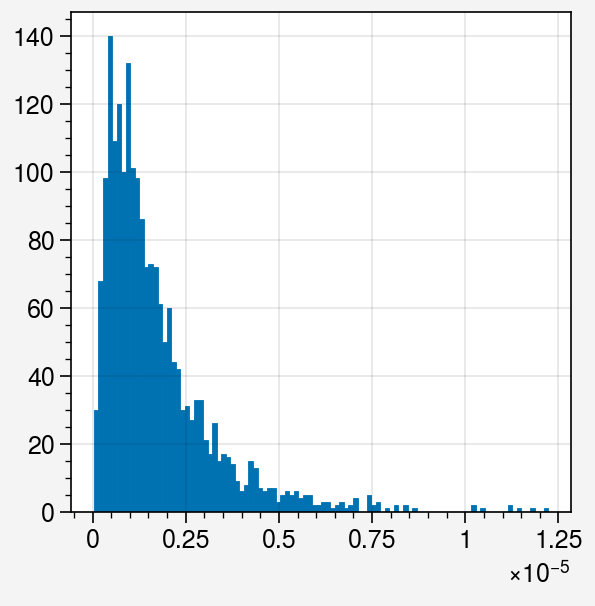

In [353]:
fig, ax = pplt.subplots()
ax.hist(data['maximum_shear_strain_rate'].values, bins=100)

In [346]:
samp_mean['L'].values

array([12.36119116, 18.02718042, 25.01402863, 34.67110181, 47.79197423,
       66.27780565])

In [350]:
for month in [5]:
    strat_samp = samples[month]
    samp_mean = strat_samp.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()   
    SE = strat_samp.groupby('log_bin').apply(lambda x: stats.sem(x['total_deformation']))
    
    # compute the standard error of the mean
    n = 400
    cv = get_cv(n)
    y = np.log(samp_mean['total_deformation'].values)
    x = np.log(samp_mean['L'].values)
    sigma = np.log(cv * SE.values)
    
    p0 = 0.3, 1 # initialize curve fit 
    popt, pcov = curve_fit(f, x, y, p0, sigma=sigma, absolute_sigma=True)
    yfit = f(x, *popt)
    beta, intercept = popt
    results_lr = linregress(x, y)
    print(month, np.round(beta,2),  np.round(intercept,2), np.round(results_lr.slope, 2), np.round(results_lr.intercept, 2))

5 -0.86 -9.71 -0.85 -9.74


<a list of 1 Line2D objects>

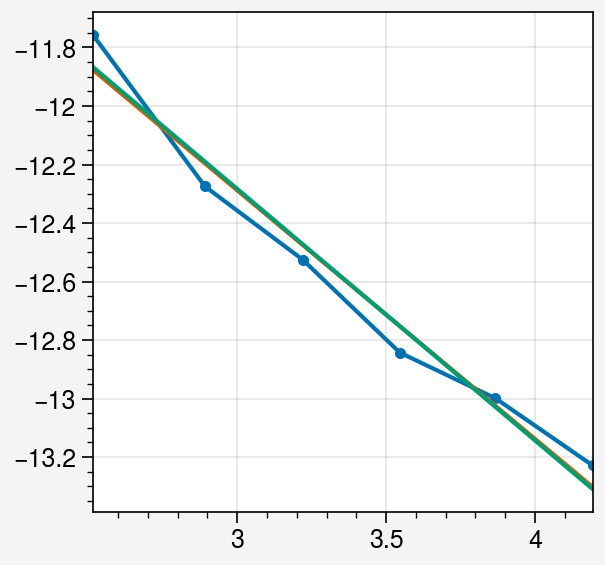

In [351]:
fig, ax = pplt.subplots()
ax.plot(x, y, marker= '.')
ax.plot(x, results_lr.slope*x + results_lr.intercept)
ax.plot(x, beta*x + intercept)

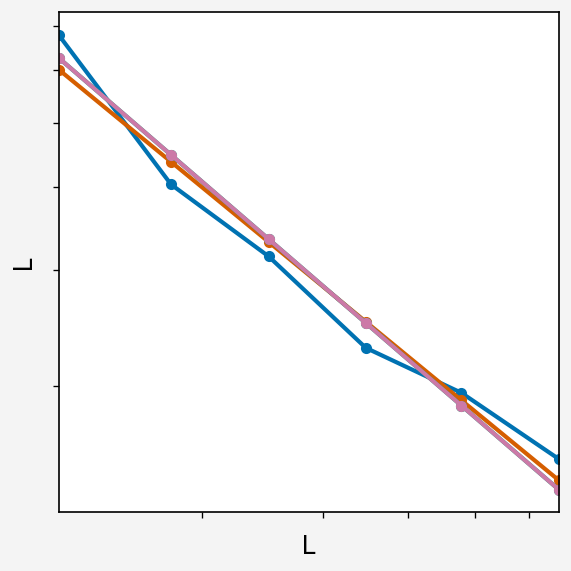

In [306]:
fig, ax = pplt.subplots()
D = samp_mean['total_deformation'].values*24*60*60
L = samp_mean['L']
ax.plot(L, D, marker= '.')
ax.plot(L, np.exp(results_lr.intercept)*(L**results_lr.slope), marker='.')
ax.plot(L, np.exp(intercept)*(L**beta), marker='.')
ax.plot(L, bs_table.loc[5, 'a_lsq']*(L**-bs_table.loc[5, 'beta_lsq']), marker='.')

ax.format(yscale='log', xscale='log')

In [293]:
for month in samples:
    strat_samp = samples[month]
    likelihood_results = pd.Series(np.nan, index=np.linspace(0.01, 1, 200))
    for beta in likelihood_results.index:
        likelihood_results.loc[beta] = normal_log_likelihood(strat_samp['total_deformation']*(60*60*24),
                                                             strat_samp['L'], beta)
    beta = likelihood_results.idxmax()
    bs_table.loc[month, 'beta_mle'] = beta 

    samp_mean = strat_samp.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()   
    SE = strat_samp.groupby('log_bin').apply(lambda x: stats.sem(x['total_deformation']))
    
    # compute the standard error of the mean
    n = 400
    cv = get_cv(n)
    y = np.log(samp_mean['total_deformation'].values*24*60*60)
    x = np.log(samp_mean['L'].values)
    sigma = np.log(cv * SE.values*24*60*60)
    
    
    p0 = 3, 1 # initialize curve fit 
    popt, pcov = curve_fit(f, x, y, p0, sigma=sigma, absolute_sigma=True)
    yfit = f(x, *popt)
    beta, intercept = popt
    
    bs_table.loc[month, 'beta_lsq'] = -beta
    bs_table.loc[month, 'a_lsq'] = np.exp(intercept)

In [294]:
bs_table

min_beta_mle  max_beta_mle  min_beta_lsq  max_beta_lsq  beta_mle  \
month                                                                     
4          0.323417      0.447789      0.429645      0.608199  0.388090   
5          0.502513      0.622034      0.655593      0.820041  0.562211   
6          0.373166      0.512587      0.467053      0.613319  0.442814   

       beta_lsq     a_lsq  
month                      
4      0.521627  1.381214  
5      0.734573  3.200928  
6      0.539629  1.933309

In [268]:
# This is the standard deviation of the error
# To get a 95% confidence interval
perr = np.sqrt(np.diag(pcov))
perr

array([ 3.74231479, 13.08699875])

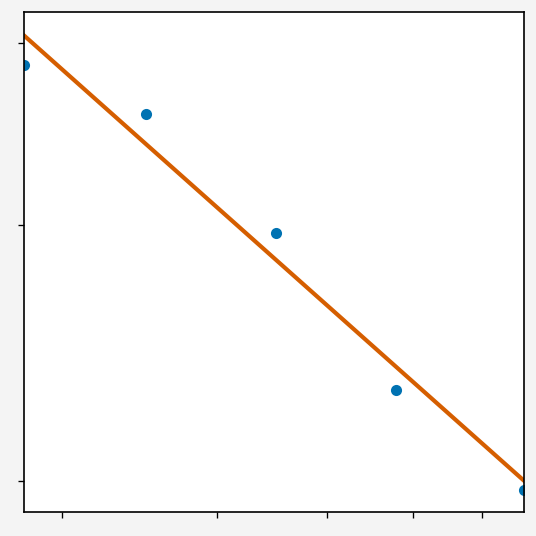

In [257]:
fig, ax = pplt.subplots()
ax.plot(np.exp(x), np.exp(y), marker='.', lw=0)
ax.plot(np.exp(x), np.exp(yfit2))
ax.format(yscale='log', xscale='log')

In [234]:
import scipy.stats as stats
n = 400
dist = stats.t(n-1)
critical_value = dist.ppf(0.975)
SE = data.groupby('log_bin').apply(lambda x: stats.sem(x['total_deformation']))

log_bin
1    1.827525e-07
2    1.922780e-07
3    1.221130e-07
4    9.756878e-08
5    7.772369e-08
dtype: float64

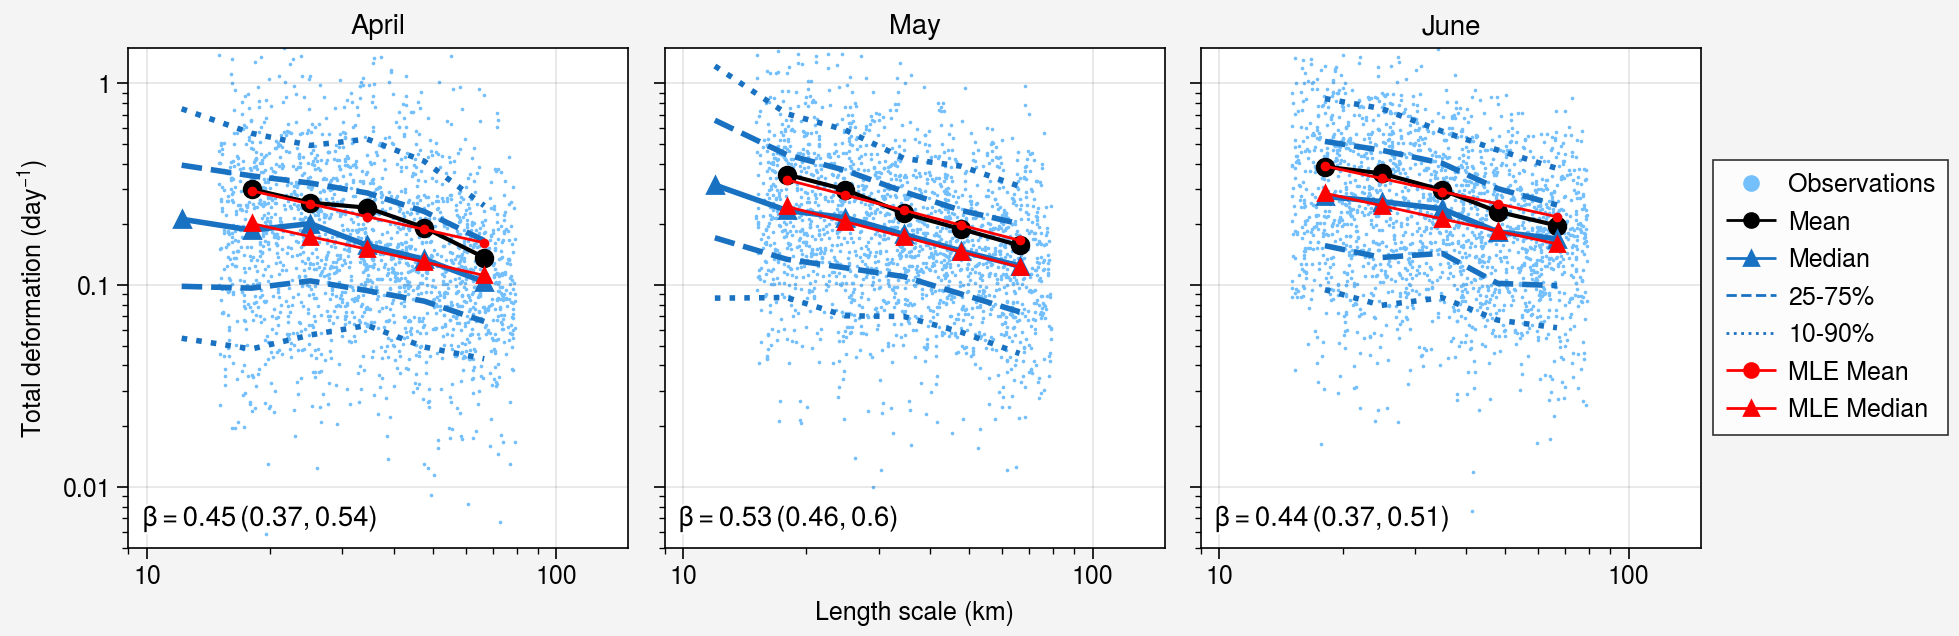

In [ ]:
    # Uncomment to plot the standard deviation
    # data_stdv = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').std()
    # ax.plot(data_mean['L'].values, data_stdv['total_deformation'].values*24*60*60, marker='+', ls='--', color='k')

    
    # ax.plot(data_mean['L'].values, (stdev*data_mean['L']**(-beta_mle)).values, label='', ls='--', color='r', marker='+', ms=5, lw=1, zorder=5)


    
    min_beta = bs_table.loc[month, 'min_beta_mle']
    max_beta = bs_table.loc[month, 'max_beta_mle']    
    mle_result = '$\\beta={b} \, ({minb}, {maxb})$'.format(b=np.round(beta_mle, 2),
                                                              minb=np.round(min_beta, 2),
                                                              maxb=np.round(max_beta, 2))
    
    # Can uncomment to show the LSQ results text summary, they are identical
    # beta_lsq = bs_table.loc[month, 'beta_lsq']
    # min_beta = bs_table.loc[month, 'min_beta_lsq']
    # max_beta = bs_table.loc[month, 'max_beta_lsq']   
    # lr_result = '$\\beta={b:.2f} \, ({minb:.2f}, {maxb:.2f})$'.format(b=np.round(beta_lsq, 2),
    #                                                                   minb=np.round(min_beta, 2),
    #                                                                   maxb=np.round(max_beta, 2))

    df_quantiles = pd.DataFrame({q: strat_samp[['log_bin', 'total_deformation']].groupby('log_bin').quantile(q).values.squeeze()
                                 for q in [0.1, 0.25, 0.5, .75, 0.9]},
             index = strat_samp[['log_bin', 'L']].groupby('log_bin').mean().values.squeeze())

    for q, ls in zip([0.1, 0.25, 0.5, .75, 0.9], [':', '--', '-', '--', ':']):
        if q == 0.5:
            m = '^'
        else:
            m = ''
        ax.plot(df_quantiles.index, df_quantiles[q].values*24*60*60, color='blue8', ls=ls, lw=2, m=m)
    # Uncomment to show LSQ results
    # ax.format(lltitle='MLE: ' + mle_result + '\n' + 'LSQ: ' + lr_result, xreverse=False)
    ax.format(lltitle=mle_result)
    ax.format(yscale='log', xscale='log', ylim=(0.005, 1.5), xlabel='Length scale (km)',
              ylabel='Total deformation (day$^{-1}$)', xlim=(9, 150), title=monthname, xreverse=False)

h = [ax.plot([],[], c=c, lw=lw, m=m, ms=ms, ls=ls) for c, lw, m, ms, ls in zip(
                ['blue3', 'k', 'blue8', 'blue8', 'blue8', 'r', 'r'],
                [0, 1, 1, 1, 1, 1, 1],
                ['o', 'o', '^', '', '', 'o', '^'],
                [5, 5, 5, 0, 0, 5, 5],
                ['', '-', '-', '--', ':', '-', '-'])]
                 #Obs / Mean / Median / 25-75

# make custom legend
ax.legend(h, ['Observations', 'Mean', 'Median', '25-75%', '10-90%', 'MLE Mean', 'MLE Median'], ncols=1,loc='r')

We consider the strain rate error following Hutchings et al. 2012:
$$\frac{\delta_\epsilon}{\epsilon} = 2\left( \$$

$\Delta T = 24 h$  
Uncertainty threshold: 10%  

Case 1: When can we neglect the velocity field and its gradients?
$$ 8 \Delta T^{-2} >> 6 (u_x^2 + v_y^2) $$
With 24 hrs, we have that 
$$ \frac{8}{6 \Delta T^2} = 1.54 \times 10^{-5} \, \text{s}^{-2}$$
or 1.3 day$^{-2}$. As mentioned by Dierking et al. (and supported by the analysis here) rates of more than this are rare.

Using the term 
$$ \frac{8 \sigma^2_{coord}}{\Delta T^2 a^2} $$
for an equalateral triangle with side length $a$, 10\% for the maximum allowable uncertainty, 24 hour time step, and 255 m for the coordinate uncertainty, we get a minimum side length for detecting divergence less than or equal to 0.5 per day, 

We next turn to sea ice deformation. Deformation estimation requires a consideration of averaging area, and thus the relationship to spatial scaling for deformation differs from that of the FSD and the velocity distributions. In addition to possible effects of floe sizes, we consider the length scale defined by the square root of the area of the triangle used in the strain rate calculation. Prior work has shown that the deformation rate has a fractal-like scale dependence such that the deformation rates are linearly related to the spatial scale in log-log space: $\dot \epsilon \sim L^{-\beta}$. This is a power law form, but does not describe a statistical power law distribution.

To fit the paper better, I need to relate the deformation to the floe-scale ice motion
- smaller floes have higher perturbation velocity --> does that correspond to large deformation?
- how much of the deformation is from the large-scale flow field vs the perturbation velocities?
- if the polygon area is similar to the floe size then we'd see more granular flow effects probably.
   - Does the grain size, perhaps the area/total floe area matter?
- To what extent does the day-to-day variation in the number of polygons matter?
  - Current version has tons of overlapping polygons
  - Better to triangulate instead?

In [6]:
# Helper function for deformation
def mean_accel(xcomp, ucomp, area, sign):
    """xcomp and ucomp input should be an N x 3 array. Different gradients will need
    different combinations of x, y, u, and v. In particular:
        dudx = accel(Y, U, A, 1)
        dudy = accel(X, U, A, -1)
        dvdx = accel(Y, V, A, 1)
        dvdy = accel(X, V, A, -1)
    xcomp should be in polar stereographic components.    
    """
    nr, nc = xcomp.shape
    total = np.zeros(nr)
    for idx in range(nc):
        idx1 = (idx + 1) % nc
        total += (ucomp[:, idx1] + ucomp[:, idx])*(xcomp[:, idx1] - xcomp[:, idx])
    return 1/(2*area) * total * sign

df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

# calculate deformation
xcoords = np.array([df['x1'], df['x2'], df['x3']]).T
ycoords = np.array([df['y1'], df['y2'], df['y3']]).T
ucoords = np.array([df['u1'], df['u2'], df['u3']]).T
vcoords = np.array([df['v1'], df['v2'], df['v3']]).T

area = df['polygon_area'].values*1e6 # convert back to meters. 

dudx = mean_accel(ycoords, ucoords, area, 1)
dudy = mean_accel(xcoords, ucoords, area, -1)
dvdx = mean_accel(ycoords, vcoords, area, 1)
dvdy = mean_accel(xcoords, vcoords, area, -1)

df['divergence'] = dudx + dvdy #div = epsilon_i
df['maximum_shear_strain_rate'] = 1/2*np.sqrt((dudx - dvdy)**2 + (dudy + dvdx)**2) 
df['vorticity'] = dvdx - dudy #vor
df['pure_shear'] = dudy + dvdx #pure
df['normal_shear'] = dudx - dvdy #normal
df['total_deformation'] = np.sqrt(df['divergence']**2 + 2*df['maximum_shear_strain_rate']**2)

In [7]:
# Keeping units in meters and meters squared

# Uncertainty
dx = 255 # m -- uncertainty in the position data

# separation distance -- neglecting for now the uncertainty in each side length
df['d12'] = np.sqrt((df['x1'] - df['x2'])**2 + (df['y1'] - df['y2'])**2)
df['d13'] = np.sqrt((df['x1'] - df['x3'])**2 + (df['y1'] - df['y3'])**2)
df['d23'] = np.sqrt((df['x3'] - df['x2'])**2 + (df['y3'] - df['y2'])**2)

df['sigma_area'] = (dx**2/4*(df['d12']**2 + df['d13']**2 + df['d23']**2))**0.5

xcoords = np.array([df['x1'], df['x2'], df['x3']]).T
ycoords = np.array([df['y1'], df['y2'], df['y3']]).T

def polygon_area_uncertainty(X, Y, position_uncertainty):
    """Compute the area uncertainty following Dierking et al. 2020"""
    N = X.shape[1]
    S = 0
    for i in range(N):
        # the modulus here makes the calculation wrap around to the beginning
        # could adjust the other codes to do this too
        S += (X[:, (i+1) % N] - X[:, (i-1) % N])**2 +  (Y[:, (i+1) % N] - Y[:, (i-1) % N])**2
    return np.sqrt(0.25*position_uncertainty**2*S)

Things to figure out still:
1. What errors are there in my calculation of the uncertainty?
2. What time error should I use for the calculations?
3. How large must the triangles be to keep the uncertainty for deformation below a given threshold?

In [8]:
sa = polygon_area_uncertainty(xcoords, ycoords, dx)

In [54]:
rel_area_unc = df['area_uncertainty'] / df['polygon_area']

In [80]:
# (0.1 * sig_div)^2 = 8 * 255**2 / (delta T^2 * a)
dx = 25
alpha = 0.05
sig_div = 0.4 / (24*60*60)
delta_T = 24*60*60

a = 8 * dx**2 / (alpha * delta_T * sig_div)**2


1.388888888888889e-05

In [89]:
np.sqrt(8) * 25 / (24*0.05*0.017)

3466.2097116987616

In [15]:
# separation distance
df['d12'] = np.sqrt((df['x1'] - df['x2'])**2 + (df['y1'] - df['y2'])**2)
df['d13'] = np.sqrt((df['x1'] - df['x3'])**2 + (df['y1'] - df['y3'])**2)
df['d23'] = np.sqrt((df['x3'] - df['x2'])**2 + (df['y3'] - df['y2'])**2)

# area fraction = total floe area divided by polygon area
df['area_fraction'] = (df['area_km21'] + df['area_km22'] + df['area_km23']) / df['polygon_area']

# mean separation dist
# separation distance accounting for floe size
d12 = np.max([np.zeros(len(df)), df['d12'] - np.sqrt(df['area_km21']) - np.sqrt(df['area_km22'])], axis=0)
d13 = np.max([np.zeros(len(df)), df['d13'] - np.sqrt(df['area_km21']) - np.sqrt(df['area_km23'])], axis=0)
d23 = np.max([np.zeros(len(df)), df['d23'] - np.sqrt(df['area_km22']) - np.sqrt(df['area_km23'])], axis=0)

df['mean_separation'] = 1/3*(d12 + d13 + d23)
df['mean_separation_ratio'] = df['mean_separation']/df['L']

Analysis procedure. For each image date, I randomly shuffled the dataset, then iteratively select polygons such that each identified ice floe is only used in one polygon per bin. The minimum and maximum bins are excluded from the analysis since they have relatively few observations and cannot be guaranteed to sample the full bin range.
- min number of obs per bin?
- resampling with different initial sets?
- is the result dependent on the minimum angle? (re-run with it set to 30 degrees)
  
We want to understand the following questions
- Do we observe a similar length scale depends with these MIZ observations as we do with previous studies?
- Does the length scale relationship vary through the summer?
- Within a given range, is (a) the lognormal MLE a consistent method to estimate the scale parameter, and (b) does the lognormal distribution describe the variability within length scale bins?
- Does the 

Emphasize that we are not testing whether deformation distributions follow a power law, we are looking at whether the deformation has a power law dependence on the length scale. We are not expecting the counts to follow any particular distribution, this is not a probability distribution function.

Goodness of fit: qq plots by bin size for each month
- question of what is happening in the tails



The area uncertainty depends on perimeter

In [16]:
import powerlaw

The relative uncertainty in area decreases as the triangle size increases. With a minimum interior angle of 20, the relative error is less than 5% for triangles with length scale of 10 km or higher, and less than 1% for triangles with length scale higher than 40 km.

In [9]:
def area_uncertainty(data, dx=256):
    a2 = (data.x1 - data.x2)**2 + (data.y1 - data.y2)**2
    b2 = (data.x1 - data.x3)**2 + (data.y1 - data.y3)**2
    c2 = (data.x3 - data.x2)**2 + (data.y3 - data.y2)**2    
    return np.sqrt(dx**2/4*(a2 + b2 + c2))

## First term: Uncertainty due to position uncertainty per area


1% threshold: 102.0 km
5% threshold: 20.0 km
10% threshold: 10.0 km


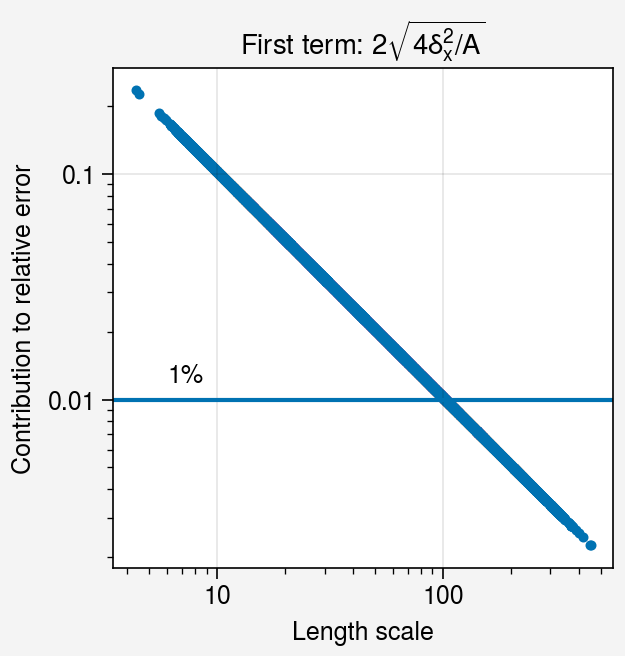

In [70]:
fig, ax = pplt.subplots()
term1 = 2*np.sqrt(4*del_x**2 / A)
ax.scatter(L, term1, marker='.')
ax.format(xscale='log', yscale='log', ylabel='Contribution to relative error', xlabel='Length scale', title='First term: 2$\sqrt{4 \delta_x^2/A}$')
ax.axhline(0.01)
ax.text(6, 0.012, '1%')
print('1% threshold:', np.round(L[term1 < 0.01].min()), 'km')
print('5% threshold:', np.round(L[term1 < 0.05].min()), 'km')
print('10% threshold:', np.round(L[term1 < 0.1].min()), 'km')

1% threshold: 102.0 km
5% threshold: 20.0 km
10% threshold: 10.0 km


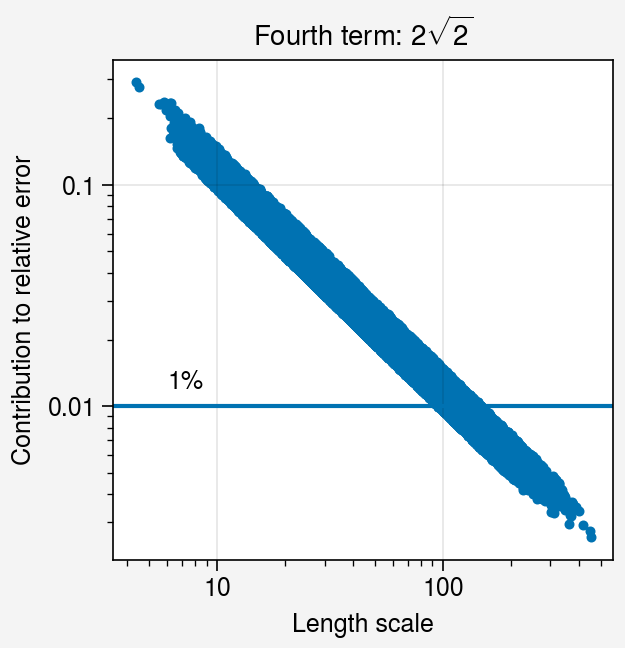

In [86]:
fig, ax = pplt.subplots()
term4 = 2*np.sqrt(2) * df['sigma_area'] / A
ax.scatter(L, term4, marker='.')
ax.format(xscale='log', yscale='log', ylabel='Contribution to relative error', xlabel='Length scale',
          title='Fourth term: 2$\sqrt{2} \frac{\delta_A}{A}$')
ax.axhline(0.01)
ax.text(6, 0.012, '1%')
print('1% threshold:', np.round(L[term1 < 0.01].min()), 'km')
print('5% threshold:', np.round(L[term1 < 0.05].min()), 'km')
print('10% threshold:', np.round(L[term1 < 0.1].min()), 'km')

1% threshold: nan km
5% threshold: 0.0 km
10% threshold: 0.0 km


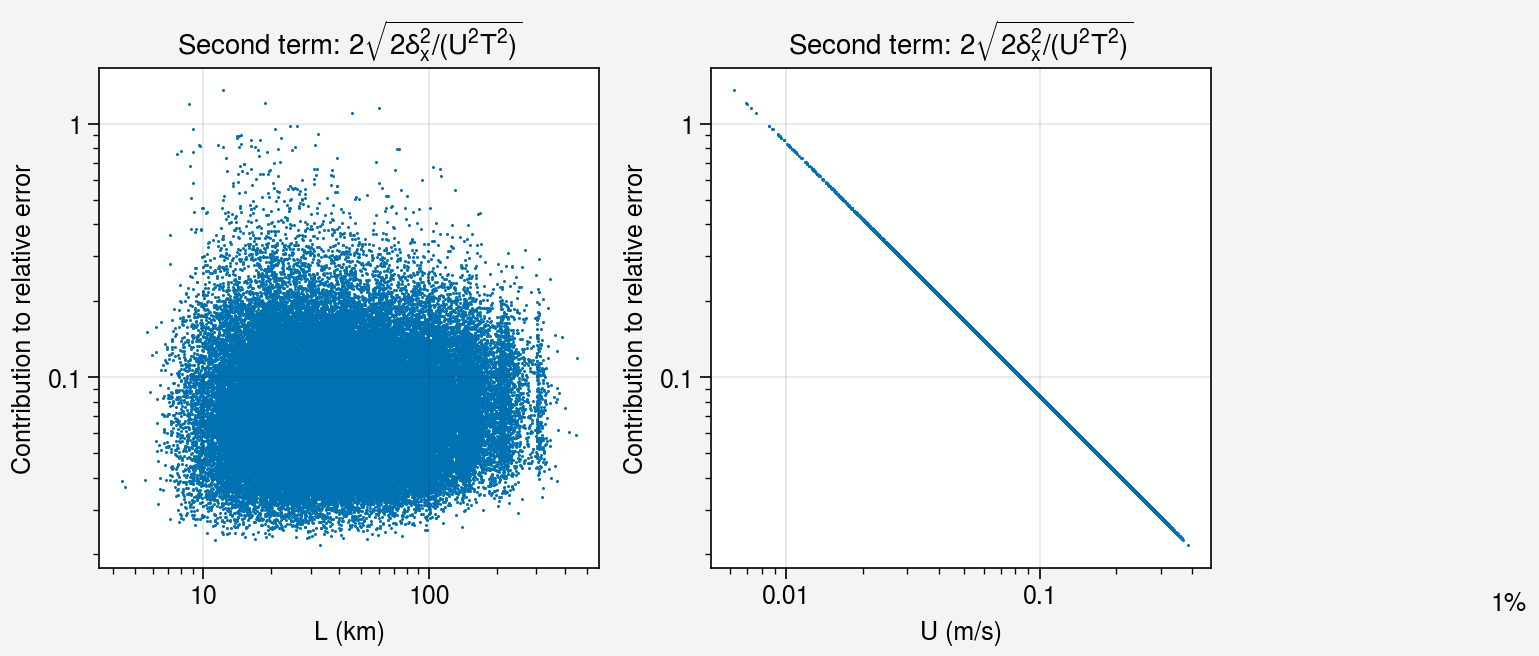

In [88]:
fig, axs = pplt.subplots(ncols=2, share=False)

# Mean U
U = ((df['u1']**2 + df['v1']**2)**0.5 + \
    (df['u2']**2 + df['v2']**2)**0.5 + \
    (df['u3']**2 + df['v3']**2)**0.5)/3

# 1-day time step
T = 24*60*60

ax = axs[0]
term2 = 2*np.sqrt(2*del_x**2 / (U**2 * T**2))
ax.scatter(L, term2, marker='.', ms=1)
ax.format(xscale='log', yscale='log', ylabel='Contribution to relative error', xlabel='L (km)',
          title='Second term: 2$\sqrt{2 \delta_x^2/(U^2T^2)}$')

ax = axs[1]
term2 = 2*np.sqrt(2*del_x**2 / (U**2 * T**2))
ax.scatter(U, term2, marker='.', ms=1)
ax.format(xscale='log', yscale='log', ylabel='Contribution to relative error', xlabel='U (m/s)',
          title='Second term: 2$\sqrt{2 \delta_x^2/(U^2T^2)}$')

# ax.axhline(0.01)
ax.text(6, 0.012, '1%')
print('1% threshold:', np.round(U[term2 < 0.01].dropna().min()), 'km')
print('5% threshold:', np.round(U[term2 < 0.05].dropna().min()), 'km')
print('10% threshold:', np.round(U[term2 < 0.1].dropna().min()), 'km')

In [82]:
2*np.sqrt(2) * 25 / (60*60)

0.019641855032959656

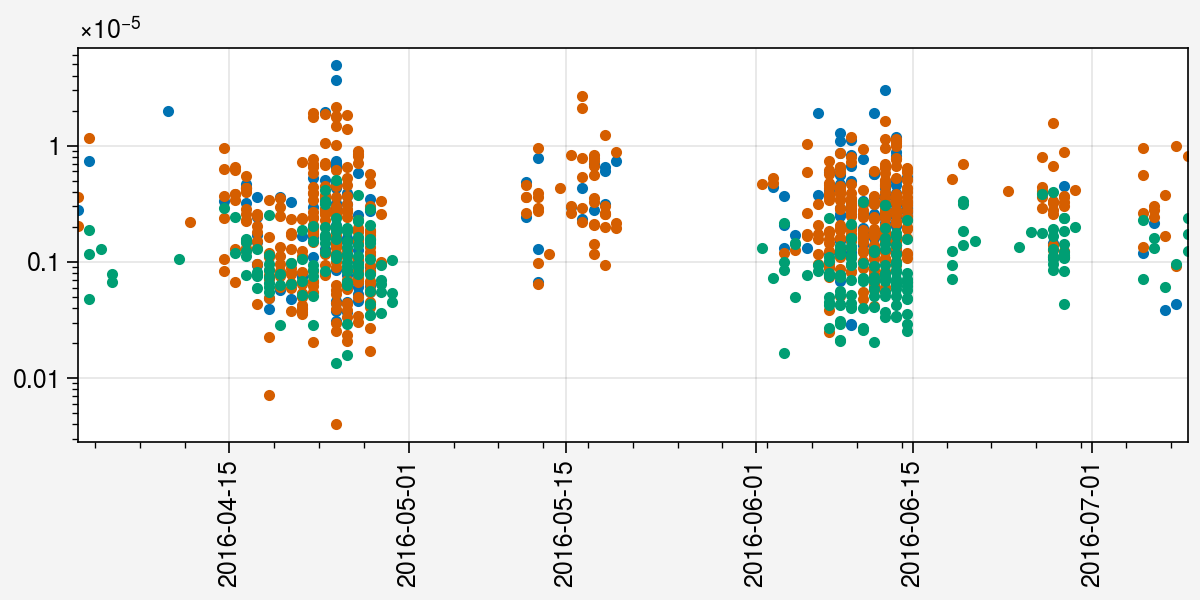

In [98]:
fig, ax = pplt.subplots(width=6, height=3)
idx = (df.log_bin == 1) & (df.datetime.dt.year == 2016)
ax.plot(df.loc[idx].datetime.values,
        df.loc[idx].total_deformation.values, marker='.',  lw=0)

idx = (df.log_bin == 3) & (df.datetime.dt.year == 2016)
ax.plot(df.loc[idx].datetime.values,
        df.loc[idx].total_deformation.values, marker='.',  lw=0)


idx = (df.log_bin == 7) & (df.datetime.dt.year == 2016)
ax.plot(df.loc[idx].datetime.values,
        df.loc[idx].total_deformation.values, marker='.',  lw=0)

ax.format(yscale='log')

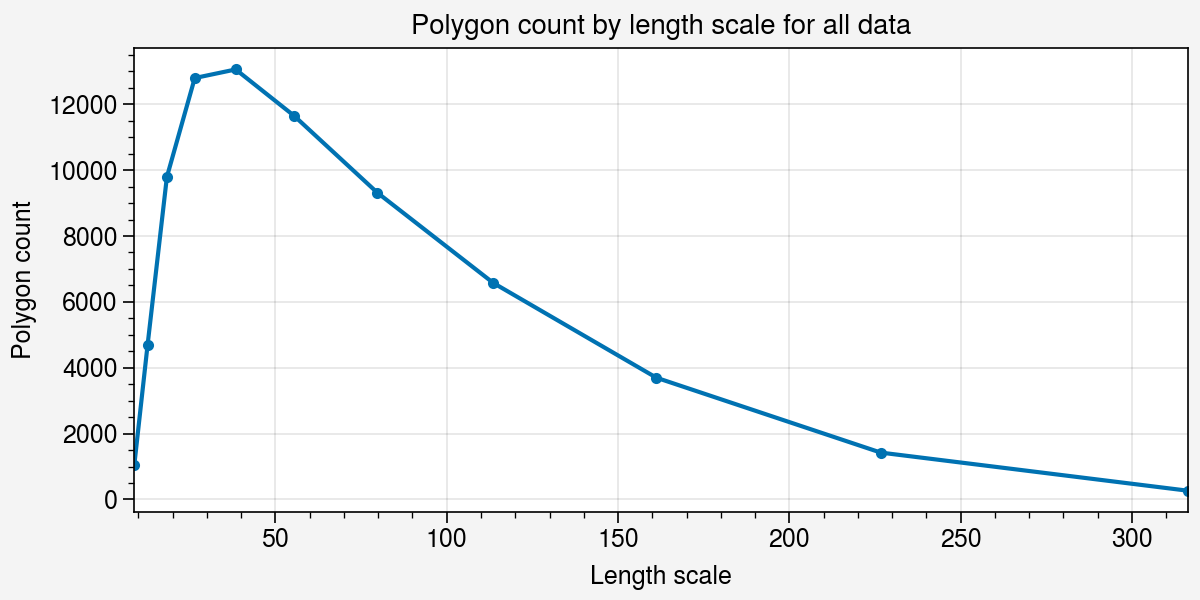

In [107]:
counts = df.groupby('log_bin').count()['datetime']
bin_mean_area = df[['log_bin', 'L']].groupby('log_bin').mean()['L']
fig, ax = pplt.subplots(width=6, height=3)
ax.plot(bin_mean_area, counts, marker='.')
ax.format(ylabel='Polygon count', xlabel='Length scale', title='Polygon count by length scale for all data')

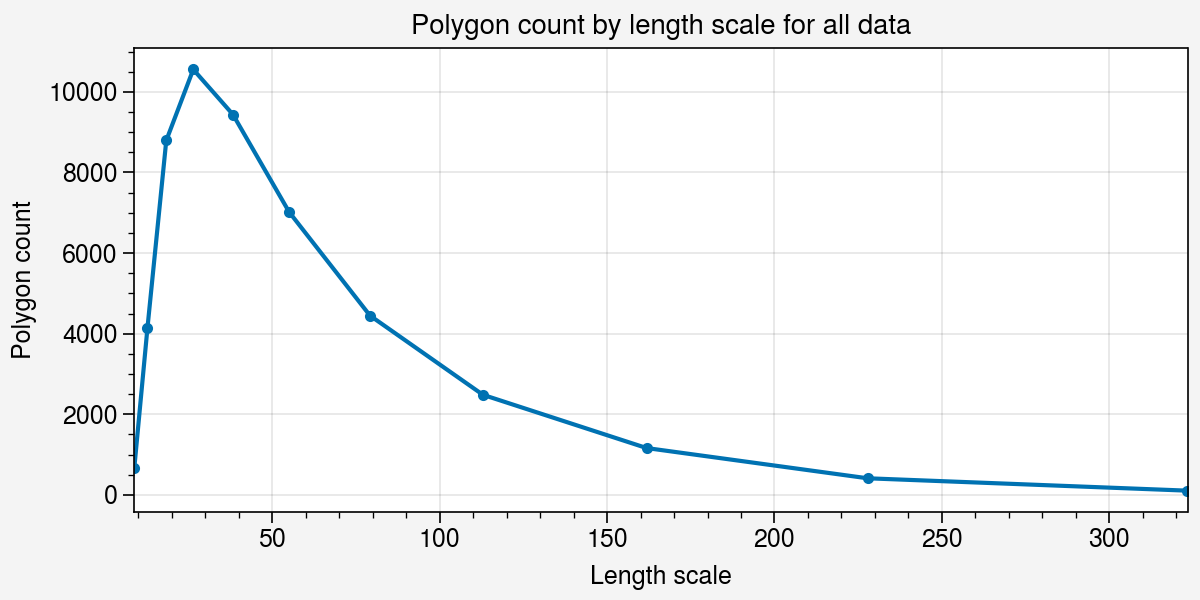

In [108]:
counts = df.loc[df.no_overlap_sample].groupby('log_bin').count()['datetime']
bin_mean_area = df.loc[df.no_overlap_sample][['log_bin', 'L']].groupby('log_bin').mean()['L']
fig, ax = pplt.subplots(width=6, height=3)
ax.plot(bin_mean_area, counts, marker='.')
ax.format(ylabel='Polygon count', xlabel='Length scale', title='Polygon count by length scale for all data')

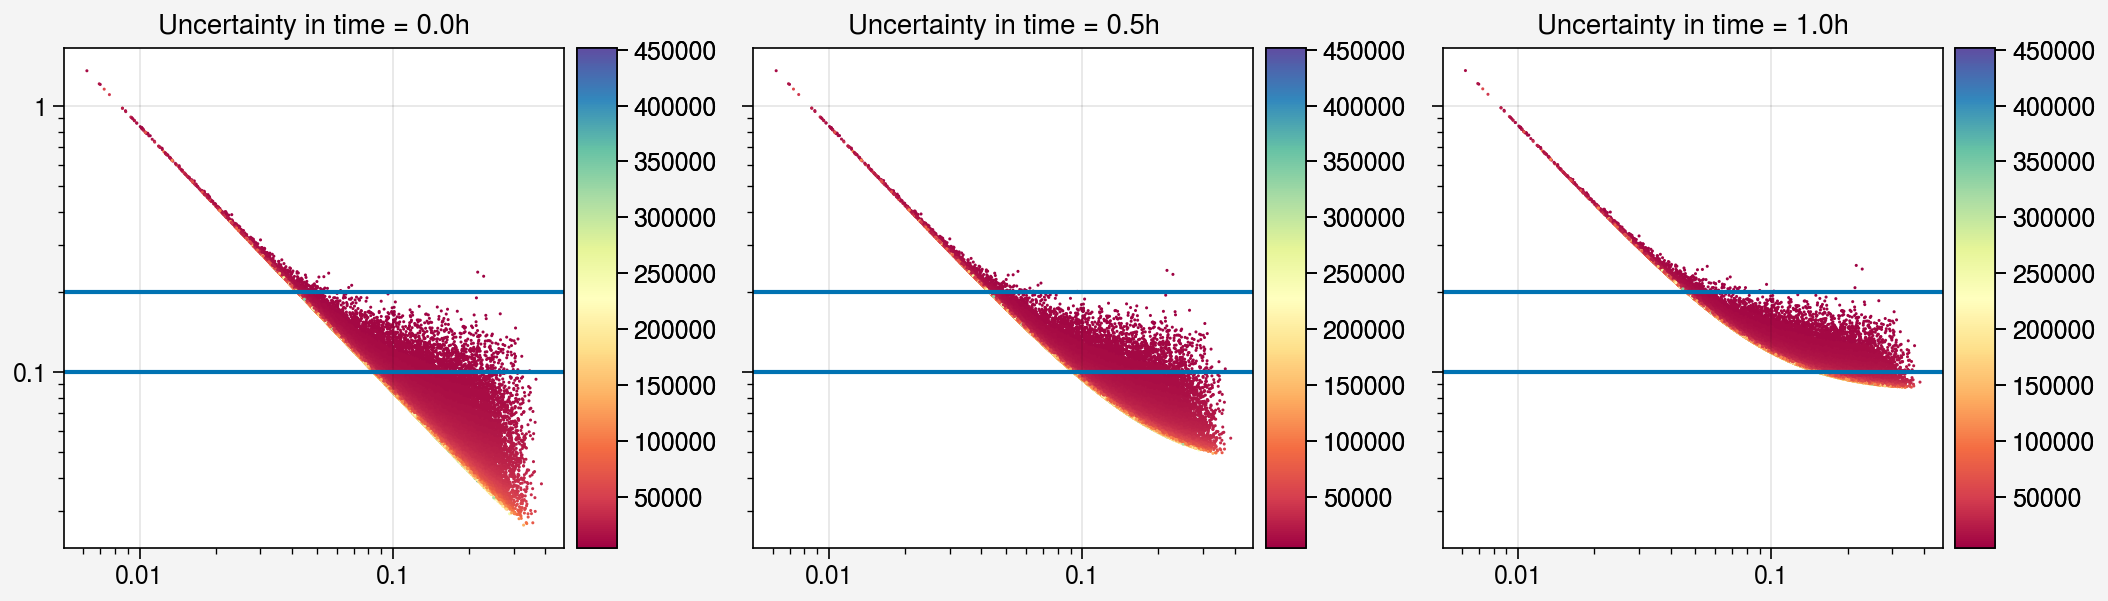

In [31]:
fig, axs = pplt.subplots(ncols=3)


# Add uncertainty calculation here
del_x = 256
T = 24*60*60 # 24 hr time step

A = df['polygon_area']*1e6 # Convert area to m2
del_A = df['sigma_area']/A

# Mean U
U = ((df['u1']**2 + df['v1']**2)**0.5 + \
    (df['u2']**2 + df['v2']**2)**0.5 + \
    (df['u3']**2 + df['v3']**2)**0.5)/3

del_T = 0*60*60 # 1 hour uncertainty in time
for ax, del_T in zip(axs, [0, 0.5*60*60, 1*60*60]):
    df['relative_error'] = 2*np.sqrt(4*del_x**2/A + \
                                    2*del_x**2/(U**2*T**2) + \
                                    del_T**2/T**2 + \
                                    del_A**2/A**2)
    
    ax.scatter(U, df['relative_error'].values, marker='.', ms=1, c=np.sqrt(A), cmap='spectral', colorbar='r')
    ax.format(xscale='log', yscale='log', title='Uncertainty in time = ' + str(del_T/(60*60)) + 'h', ylabel=')
    ax.axhline(0.2)
    ax.axhline(0.1)

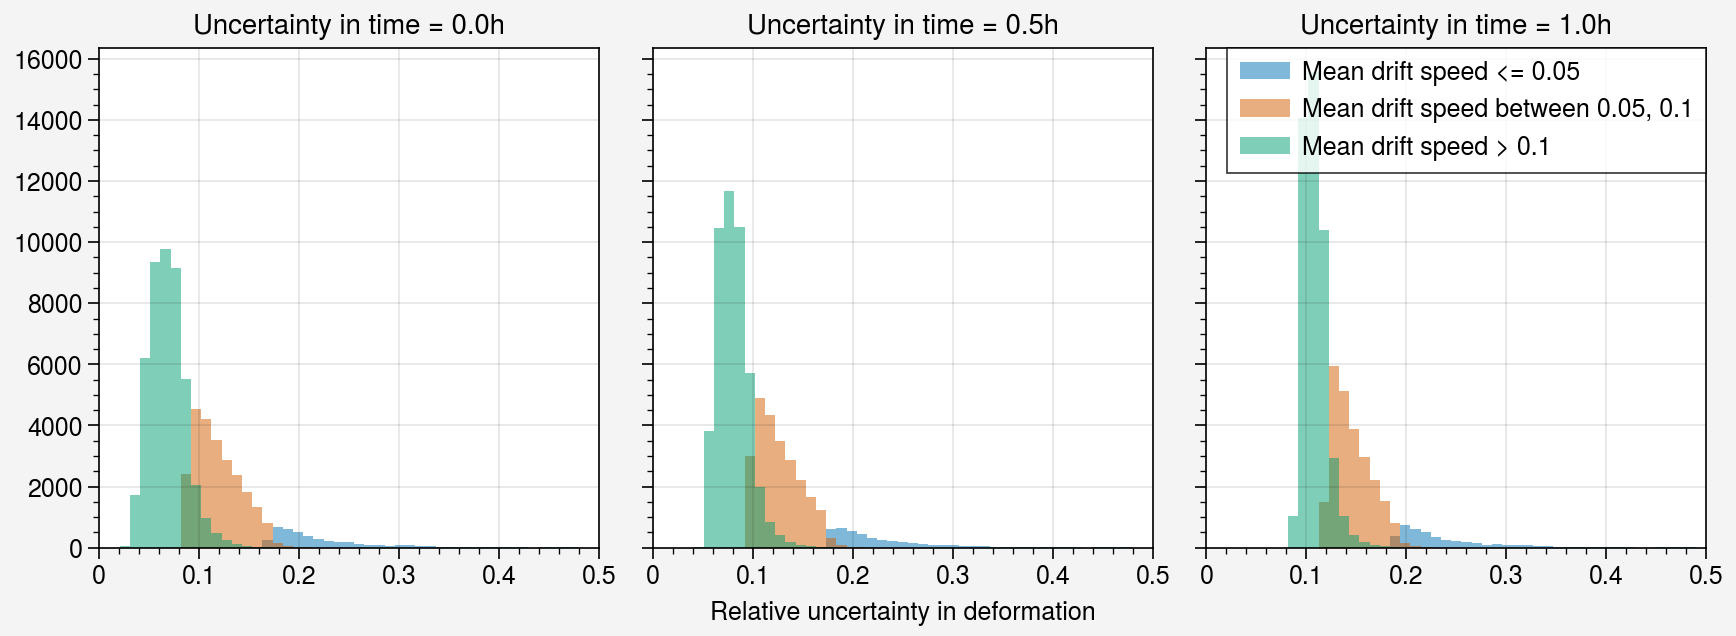

In [42]:
fig, axs = pplt.subplots(ncols=3)


# Add uncertainty calculation here
del_x = 256
T = 24*60*60 # 24 hr time step

A = df['polygon_area']*1e6 # Convert area to m2
del_A = df['sigma_area']/A

# Mean U
U = ((df['u1']**2 + df['v1']**2)**0.5 + \
    (df['u2']**2 + df['v2']**2)**0.5 + \
    (df['u3']**2 + df['v3']**2)**0.5)/3

del_T = 0*60*60 # 1 hour uncertainty in time
for ax, del_T in zip(axs, [0, 0.5*60*60, 1*60*60]):
    df['relative_error'] = 2*np.sqrt(4*del_x**2/A + \
                                    2*del_x**2/(U**2*T**2) + \
                                    del_T**2/T**2 + \
                                    del_A**2/A**2)
    ax.hist(df['relative_error'].loc[U <= 0.05].values, bins=np.linspace(0, 0.5, 50), alpha=0.5, label='Mean drift speed <= 0.05')
    ax.hist(df['relative_error'].loc[(U > 0.05) & (U <= 0.1)].values, bins=np.linspace(0, 0.5, 50), alpha=0.5, label='Mean drift speed between 0.05, 0.1')
    ax.hist(df['relative_error'].loc[U > 0.1].values, bins=np.linspace(0, 0.5, 50), alpha=0.5, label='Mean drift speed > 0.1')
    ax.format(title='Uncertainty in time = ' + str(del_T/(60*60)) + 'h', xlim=(0, 0.5), xlabel='Relative uncertainty in deformation')
ax.legend(ncols=1)

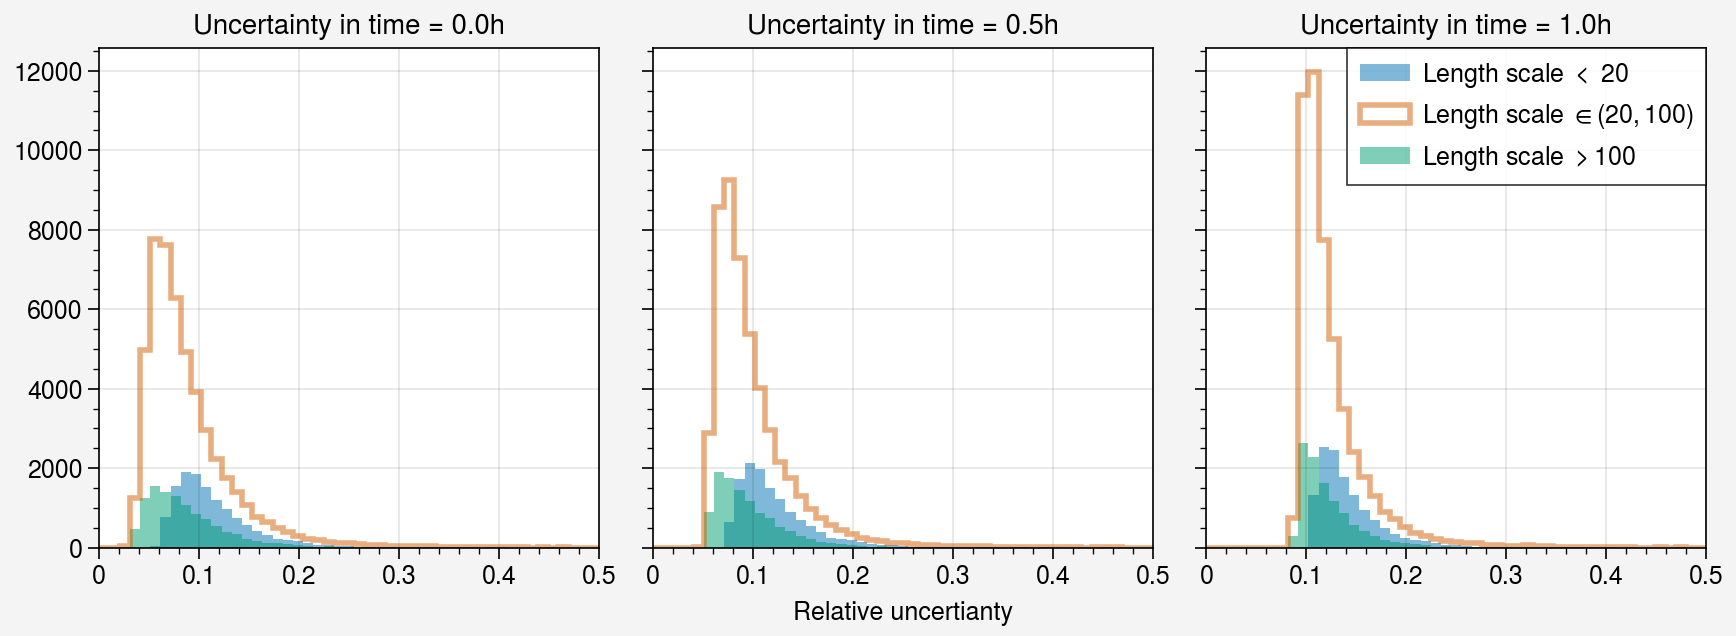

In [48]:

fig, axs = pplt.subplots(ncols=3)

# Add uncertainty calculation here
del_x = 256
T = 24*60*60 # 24 hr time step

A = df['polygon_area']*1e6 # Convert area to m2
L = df['L']
del_A = df['sigma_area']/A

# Mean U
U = ((df['u1']**2 + df['v1']**2)**0.5 + \
    (df['u2']**2 + df['v2']**2)**0.5 + \
    (df['u3']**2 + df['v3']**2)**0.5)/3

del_T = 0*60*60 # 1 hour uncertainty in time
for ax, del_T in zip(axs, [0, 0.5*60*60, 1*60*60]):
    df['relative_error'] = 2*np.sqrt(4*del_x**2/A + \
                                    2*del_x**2/(U**2*T**2) + \
                                    del_T**2/T**2 + \
                                    del_A**2/A**2)
    ax.hist(df['relative_error'].loc[L <= 20].values, bins=np.linspace(0, 0.5, 50), alpha=0.5, label='Length scale $<$ 20')
    ax.hist(df['relative_error'].loc[(L > 20) & (L <= 100)].values, bins=np.linspace(0, 0.5, 50), alpha=0.5, label='Length scale $\\in (20, 100)$',
           histtype='step', lw=2)
    ax.hist(df['relative_error'].loc[L > 100].values, bins=np.linspace(0, 0.5, 50), alpha=0.5, label='Length scale $>100$')
    ax.format(title='Uncertainty in time = ' + str(del_T/(60*60)) + 'h', xlim=(0, 0.5), xlabel='Relative uncertianty')
ax.legend(ncols=1)

(array([ 2743., 16047., 20198., 16330., 10431.,  5562.,  2152.,   642.,
          177.,    23.]),
 array([0.00619791, 0.04414281, 0.0820877 , 0.1200326 , 0.15797749,
        0.19592239, 0.23386728, 0.27181218, 0.30975707, 0.34770197,
        0.38564686]),
 <BarContainer object of 10 artists>)

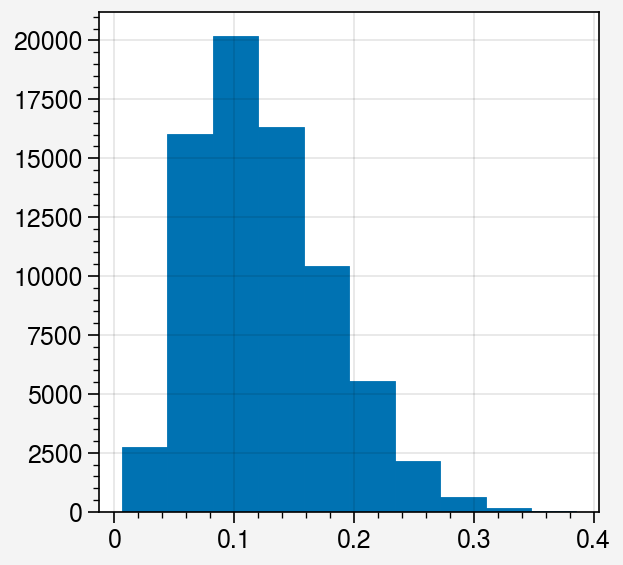

In [40]:
fig, ax = pplt.subplots()
ax.hist(U)

In [29]:
%%time
# Stratified sample by log bin
rs = 32413
n = 500
samples = {4: [], 5: [], 6: []}
for (month, log_bin), group in df.loc[df['no_overlap_sample'], :].groupby(['month', 'log_bin']):         
    if len(group) >= n:
        if month in samples:
            # weight by the number of observations from that date
            w = 1 / group.groupby('datetime').transform(lambda x: len(x))['triangle_number']
            samples[month].append(group.sample(n, replace=False, weights=w, random_state=rs + month + log_bin))
            # weight this by the number of observations per day within each bin
    else:
        pass
        
        # print(month, log_bin, len(group))
for month in samples:
    samples[month] = pd.concat(samples[month])

CPU times: user 2.12 s, sys: 14.1 ms, total: 2.13 s
Wall time: 2.13 s


(array([  738.,  2327.,  4093.,  6571.,  9206.,  9575.,  8879.,  8471.,
         8617., 15828.]),
 array([0.00160882, 0.10144794, 0.20128706, 0.30112618, 0.40096529,
        0.50080441, 0.60064353, 0.70048265, 0.80032176, 0.90016088,
        1.        ]),
 <BarContainer object of 10 artists>)

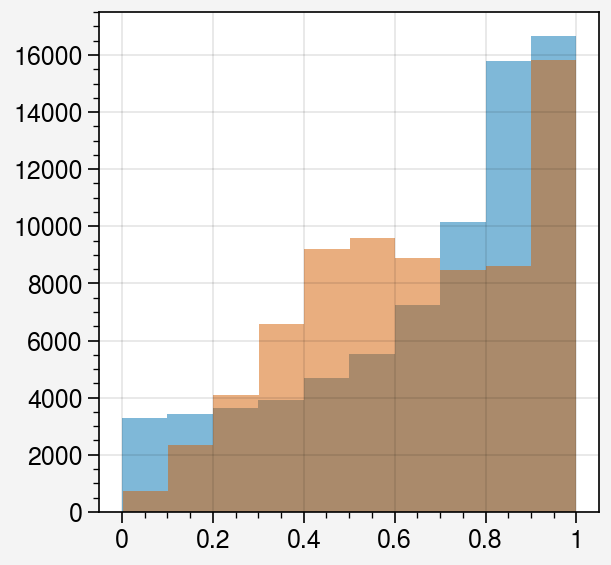

In [46]:
A = np.abs(df['divergence']) / df['total_deformation']
B = np.abs(df['maximum_shear_strain_rate']) / df['total_deformation']
fig, ax = pplt.subplots()
ax.hist(A, alpha=0.5)
ax.hist(B, alpha=0.5)

# Sensitivity of the likelihood results to the sample size
Some questions here: we're using MLE to find the slope. The new sampling method does show some differences, particularly for April. I need to figure out how things vary by length scale, and whether I'm getting the best fit with the lognormal functions. 



In [ ]:
%%time
from scipy.stats import linregress
# Build bootstrap analysis of slopes
bs_table = []
for month in samples:
    strat_samp = samples[month]
    strat_samp = strat_samp.loc[(strat_samp['log_bin'] > 0) & (strat_samp['log_bin'] < 10)]
    mle_results = []
    ls_results = []
    for repeat in range(1000):
        resamp = strat_samp.sample(len(strat_samp), replace=True, random_state=rs + repeat)

        # MLE method - could adjust the function to accept the same data
        likelihood_results = pd.Series(np.nan, index=np.linspace(0.01, 1, 200))
        for beta in likelihood_results.index:
            likelihood_results.loc[beta] = normal_log_likelihood(resamp['total_deformation']*(60*60*24),
                                                                 resamp['L'], beta)
        # if the idxmax() is equal to one side or the other, then it didn't find a maximum.
        first = np.abs(likelihood_results.idxmax() - likelihood_results.values[0]) < 1e-5
        last = np.abs(likelihood_results.idxmax() - likelihood_results.values[-10]) < 1e-5
        if not (first | last):
            mle_results.append(likelihood_results.idxmax())
        del likelihood_results

        beta, a, r, p, err = linregress(np.log(resamp['L']), np.log(resamp['total_deformation']*24*60*60))
        ls_results.append(-beta)
    
    q1_mle, q2_mle = np.quantile(np.array(mle_results), [0.025, 0.975])
    q1_ls, q2_ls = np.quantile(np.array(ls_results), [0.025, 0.975])
    bs_table.append([month, q1_mle, q2_mle, q1_ls, q2_ls])
    
bs_table = pd.DataFrame(bs_table, columns=['month', 'min_beta_mle', 'max_beta_mle', 'min_beta_lsq', 'max_beta_lsq']).set_index('month')
bs_table['beta_mle'] = np.nan
bs_table['beta_lsq'] = np.nan

In [37]:
for month in samples:
    strat_samp = samples[month]
    strat_samp = strat_samp.loc[(strat_samp['log_bin'] > 0) & (strat_samp['log_bin'] < 10)]
    likelihood_results = pd.Series(np.nan, index=np.linspace(0.01, 1, 200))
    for beta in likelihood_results.index:
        likelihood_results.loc[beta] = normal_log_likelihood(strat_samp['total_deformation']*(60*60*24),
                                                             strat_samp['L'], beta)
    beta = likelihood_results.idxmax()
    bs_table.loc[month, 'beta_mle'] = beta

    data_mean = strat_samp.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
    data_std = strat_samp.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').std()
    n = strat_samp.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').count()
    if len(data_mean) > 5:
        beta, a, r, p, err = linregress(np.log(strat_samp['L']), np.log(strat_samp['total_deformation']*24*60*60))

        bs_table.loc[month, 'beta_lsq'] = -beta
        bs_table.loc[month, 'a_lsq'] = a

# Standard approach
The typical approach, used by e.g. Hutchings et al. 2024, involves calculating a mean deformation within length scale bins. 

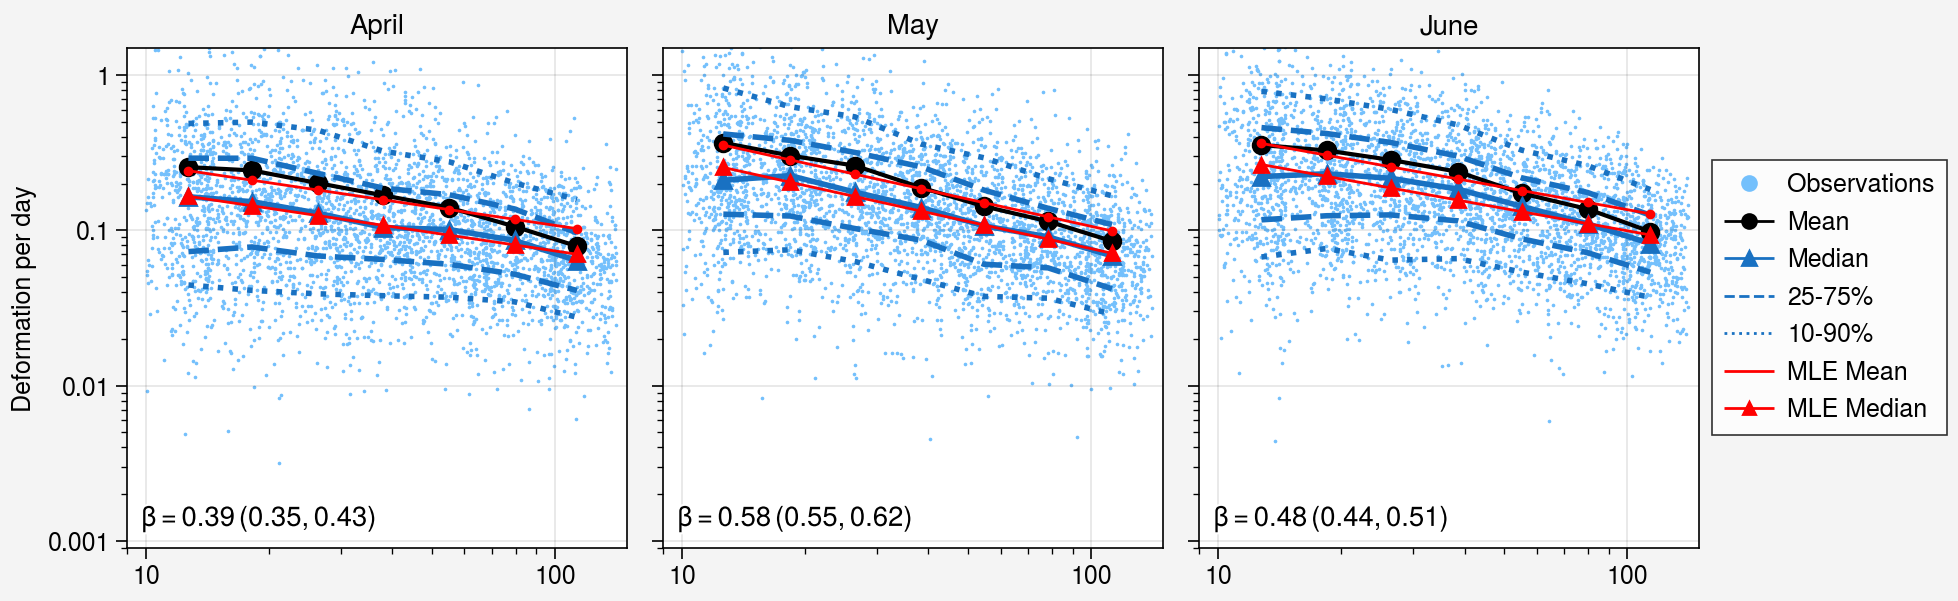

In [41]:
from scipy.stats import linregress
bs_table['reg_est'] = np.nan
fig, axs = pplt.subplots(ncols=3)
for ax, month, monthname in zip(axs, range(4, 7), ['April', 'May', 'June']):
    strat_samp = samples[month]
    strat_samp['log_total_deformation'] = np.log(strat_samp['total_deformation'])
    data = strat_samp.loc[(strat_samp.datetime.dt.month == month) & (strat_samp.no_overlap_sample)]
    data = data.loc[(data.log_bin > 0) & (data.log_bin < 10)]
    ax.scatter(data['L'].values, data['total_deformation'].values*24*60*60, m='.', color='blue3', ms=2, zorder=0, label='')
    data_mean = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
    ax.plot(data_mean['L'].values, data_mean['total_deformation'].values*24*60*60, marker='o', color='k')
    # data_std = data.loc[:, ['L', 'log_total_deformation', 'log_bin']].groupby('log_bin').std()
    
    n = data.loc[:, ['L', 'total_deformation', 'log_bin']].groupby('log_bin').count()
    
    beta_mle = bs_table.loc[month, 'beta_mle']
    scaled_eps = data['total_deformation']*(60*60*24)*data['L']**beta_mle
    mu = np.mean(np.log(scaled_eps))
    sigma = np.std(np.log(scaled_eps))
    mean = np.exp(mu + sigma**2/2)
    ax.plot(data_mean['L'].values, (np.exp(mu)*data_mean['L']**(-beta_mle)).values, label='', color='r', marker='^', ms=5, lw=1, zorder=5)
    ax.plot(data_mean['L'].values, (mean*data_mean['L']**(-beta_mle)).values, label='', color='r', marker='.', ms=5, lw=1, zorder=5)
  
    min_beta = bs_table.loc[month, 'min_beta_mle']
    max_beta = bs_table.loc[month, 'max_beta_mle']    
    mle_result = '$\\beta={b} \, ({minb}, {maxb})$'.format(b=np.round(beta_mle, 2),
                                                              minb=np.round(min_beta, 2),
                                                              maxb=np.round(max_beta, 2))
    # get 95% confidence interval using standard error and t distribution
    # # tinv = lambda p, df: abs(t.ppf(p/2, df))
    # # ts = tinv(0.01, len(data_mean) - 2)

    # lr_result = '$\\beta={s:.2f} \, ({lb:.2f}, {ub:.2f})$'.format(s=-beta,
    #                                           lb=-(beta + ts*err),
    #                                           ub=-(beta - ts*err))
    beta_lsq = bs_table.loc[month, 'beta_lsq']
    min_beta = bs_table.loc[month, 'min_beta_lsq']
    max_beta = bs_table.loc[month, 'max_beta_lsq']   
    lr_result = '$\\beta={b:.2f} \, ({minb:.2f}, {maxb:.2f})$'.format(b=np.round(beta_lsq, 2),
                                                                      minb=np.round(min_beta, 2),
                                                                      maxb=np.round(max_beta, 2))
    #                                           lb=-(beta + ts*err),
    #                                           ub=-(beta - ts*err))

    df_quantiles = pd.DataFrame({q: strat_samp[['log_bin', 'total_deformation']].groupby('log_bin').quantile(q).values.squeeze()
                                 for q in [0.1, 0.25, 0.5, .75, 0.9]},
             index = strat_samp[['log_bin', 'L']].groupby('log_bin').mean().values.squeeze())

    for q, ls in zip([0.1, 0.25, 0.5, .75, 0.9], [':', '--', '-', '--', ':']):
        if q == 0.5:
            m = '^'
        else:
            m = ''
        ax.plot(df_quantiles.index, df_quantiles[q].values*24*60*60, color='blue8', ls=ls, lw=2, m=m)
    # ax.format(lltitle='MLE: ' + mle_result + '\n' + 'LSQ: ' + lr_result, xreverse=False)
    ax.format(lltitle=mle_result)
    ax.format(yscale='log', xscale='log', ylim=(0.9e-3, 1.5), ylabel='Deformation per day', xlim=(9, 150), title=monthname, xreverse=False)

h = [ax.plot([],[], c=c, lw=lw, m=m, ms=ms, ls=ls) for c, lw, m, ms, ls in zip(
                ['blue3', 'k', 'blue8', 'blue8', 'blue8', 'r', 'r'],
                [0, 1, 1, 1, 1, 1, 1],
                ['o', 'o', '^', '', '', '.', '^'],
                [5, 5, 5, 0, 0, 0, 4, 5],
                ['', '-', '-', '--', ':', '-', '-'])]
 

# make custom legend
ax.legend(h, ['Observations', 'Mean', 'Median', '25-75%', '10-90%', 'MLE Mean', 'MLE Median'], ncols=1,loc='r')
# fig.save('../figures/fig10_deformation_scales.png', dpi=300)

In [366]:
import pandas as pd
import powerlaw
import numpy as np
# import statsmodels as sm
import proplot as pplt

df = pd.read_csv('../data/deformation/sampled_results.csv', parse_dates = ['datetime'], index_col=0)
df['month'] = df.datetime.dt.month
bs_table = pd.read_csv('../data/deformation/scaling_estimates.csv', index_col='month')

###### Calculating beta #######
# Stratified sample by log bin
# rs = 32413 number used for plot
rs = 134
n = 400 # Had done 500 before.
samples = {4: [], 5: [], 6: []}
# for (month, log_bin), group in df.loc[df['unique_floes_sample'], :].groupby(['month', 'log_bin']):         
for (month, log_bin), group in df.loc[df['no_overlap_sample'], :].groupby(['month', 'log_bin']):         
    if len(group) >= n:
        if month in samples:
            # weight by the number of observations from that date
            w = 1 / group.groupby('datetime').transform(lambda x: len(x))['triangle_number']
            samples[month].append(group.sample(n, replace=False, weights=w, random_state=rs + month + log_bin))
            # weight this by the number of observations per day within each bin
    else:
        pass

for month in samples:
    samples[month] = pd.concat(samples[month], axis=0)


There are two main ways I want to talk about the the results of the distribution
- First, comparison with the lognormal fit. The assumption is that a single beta parameter describes the distribution. However, we see that this assumption results in biased estimates of the median across scales, and an assumption of constant slope for both the mean and the median. What we are seeing is that the distribution is changing in time.
- Second, I want to use the power law function to evaluate the goodness of fit of the various distributions. Can we describe the data as lognormal?

In [361]:
len(df)

56810

log bin:  1


Calculating best minimal value for power law fit


LN vs EXP (17.241183923046993, 0.007203871281683153)
LN vs PL (12.533562141247259, 0.001208838657708392)
LN vs TPL (-2.1139732764119303, 0.006476423375064629)


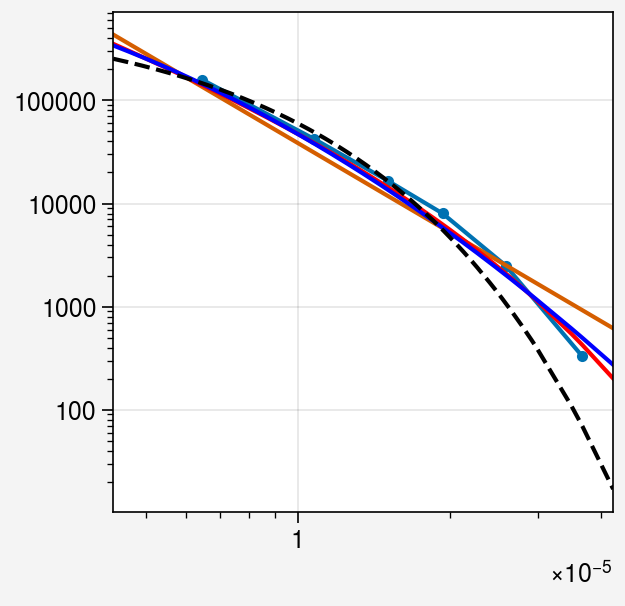

In [371]:
print("log bin: ", 1)
data = df.loc[(df.log_bin == 1) & df.no_overlap_sample]
fit = powerlaw.Fit(data['total_deformation'])
fig, ax = pplt.subplots()
fit.plot_pdf(ax=ax, marker='.')
fit.power_law.plot_pdf(ax=ax)
fit.truncated_power_law.plot_pdf(ax=ax, color='r')
fit.lognormal.plot_pdf(ax=ax, color='b')
fit.exponential.plot_pdf(ax=ax, color='k', ls='--')
print('LN vs EXP', fit.distribution_compare('lognormal', 'exponential'))
print('LN vs PL', fit.distribution_compare('lognormal', 'power_law'))
print('LN vs TPL', fit.distribution_compare('lognormal', 'truncated_power_law'))

log bin:  2


Calculating best minimal value for power law fit


LN vs EXP (3.9243095407084416, 0.1607129069973361)
LN vs PL (3.3064528593339197, 0.09415153195672338)
LN vs TPL (-0.785525885197659, 0.0029542664640585196)


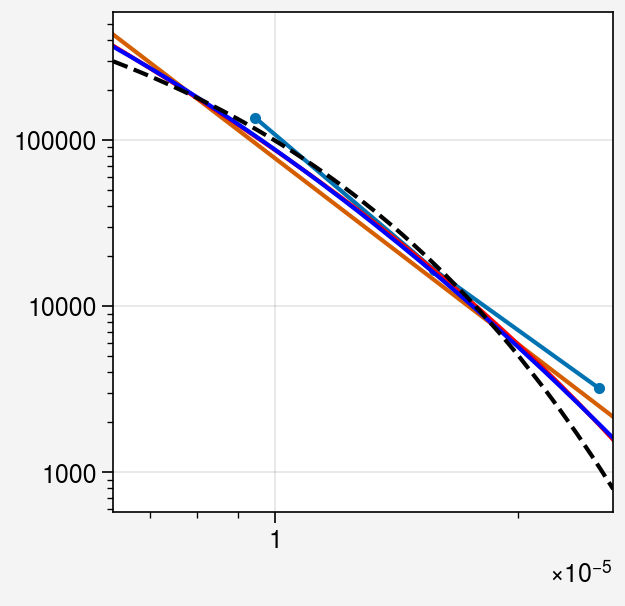

In [372]:
print("log bin: ", 2)
data = df.loc[(df.log_bin == 2) & df.no_overlap_sample]
fit = powerlaw.Fit(data['total_deformation'])
fig, ax = pplt.subplots()
fit.plot_pdf(ax=ax, marker='.')
fit.power_law.plot_pdf(ax=ax)
fit.truncated_power_law.plot_pdf(ax=ax, color='r')
fit.lognormal.plot_pdf(ax=ax, color='b')
fit.exponential.plot_pdf(ax=ax, color='k', ls='--')
print('LN vs EXP', fit.distribution_compare('lognormal', 'exponential'))
print('LN vs PL', fit.distribution_compare('lognormal', 'power_law'))
print('LN vs TPL', fit.distribution_compare('lognormal', 'truncated_power_law'))

SubplotGrid(nrows=1, ncols=1, length=1)

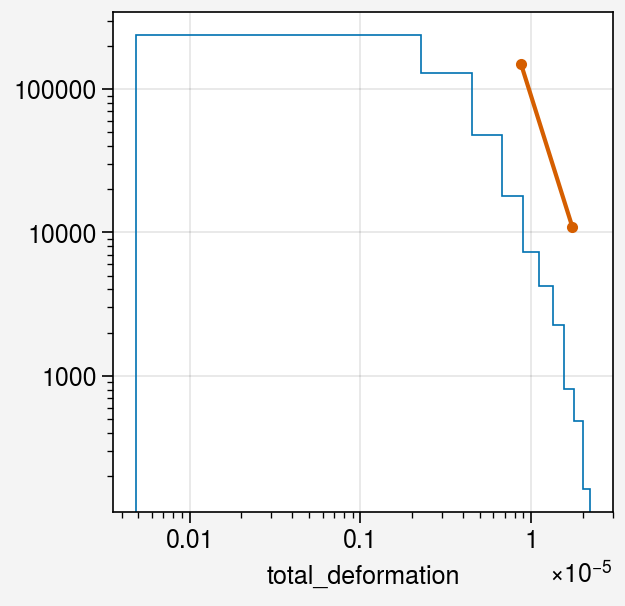

In [383]:
fig, ax = pplt.subplots()
ax.hist(data['total_deformation'], histtype='step', density=True)
ax.format(yscale='log', xscale='log')
fit.plot_pdf(ax=ax, marker='.')

log bin:  3


Calculating best minimal value for power law fit


LN vs EXP (0.45009120462028473, 0.7549662401379139)
LN vs PL (4.524839174037281, 0.05137306357191173)
LN vs TPL (-0.7484325602114756, 0.007871073106518842)


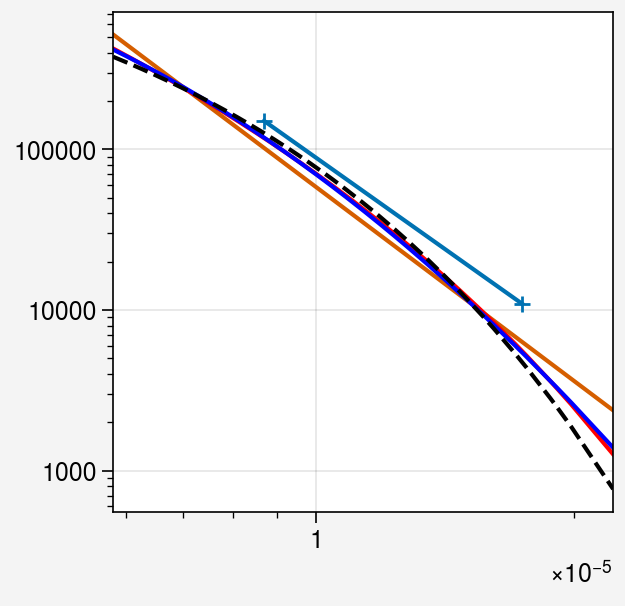

In [377]:
print("log bin: ", 3)
data = df.loc[(df.log_bin == 3) & df.no_overlap_sample]
fit = powerlaw.Fit(data['total_deformation'])
fig, ax = pplt.subplots()
fit.plot_pdf(ax=ax, marker='.')
fit.power_law.plot_pdf(ax=ax)
fit.truncated_power_law.plot_pdf(ax=ax, color='r')
fit.lognormal.plot_pdf(ax=ax, color='b')
fit.exponential.plot_pdf(ax=ax, color='k', ls='--')
print('LN vs EXP', fit.distribution_compare('lognormal', 'exponential'))
print('LN vs PL', fit.distribution_compare('lognormal', 'power_law'))
print('LN vs TPL', fit.distribution_compare('lognormal', 'truncated_power_law'))

Bin 4: No significant differences in quality of fit

In [64]:
import statsmodels.api as sm

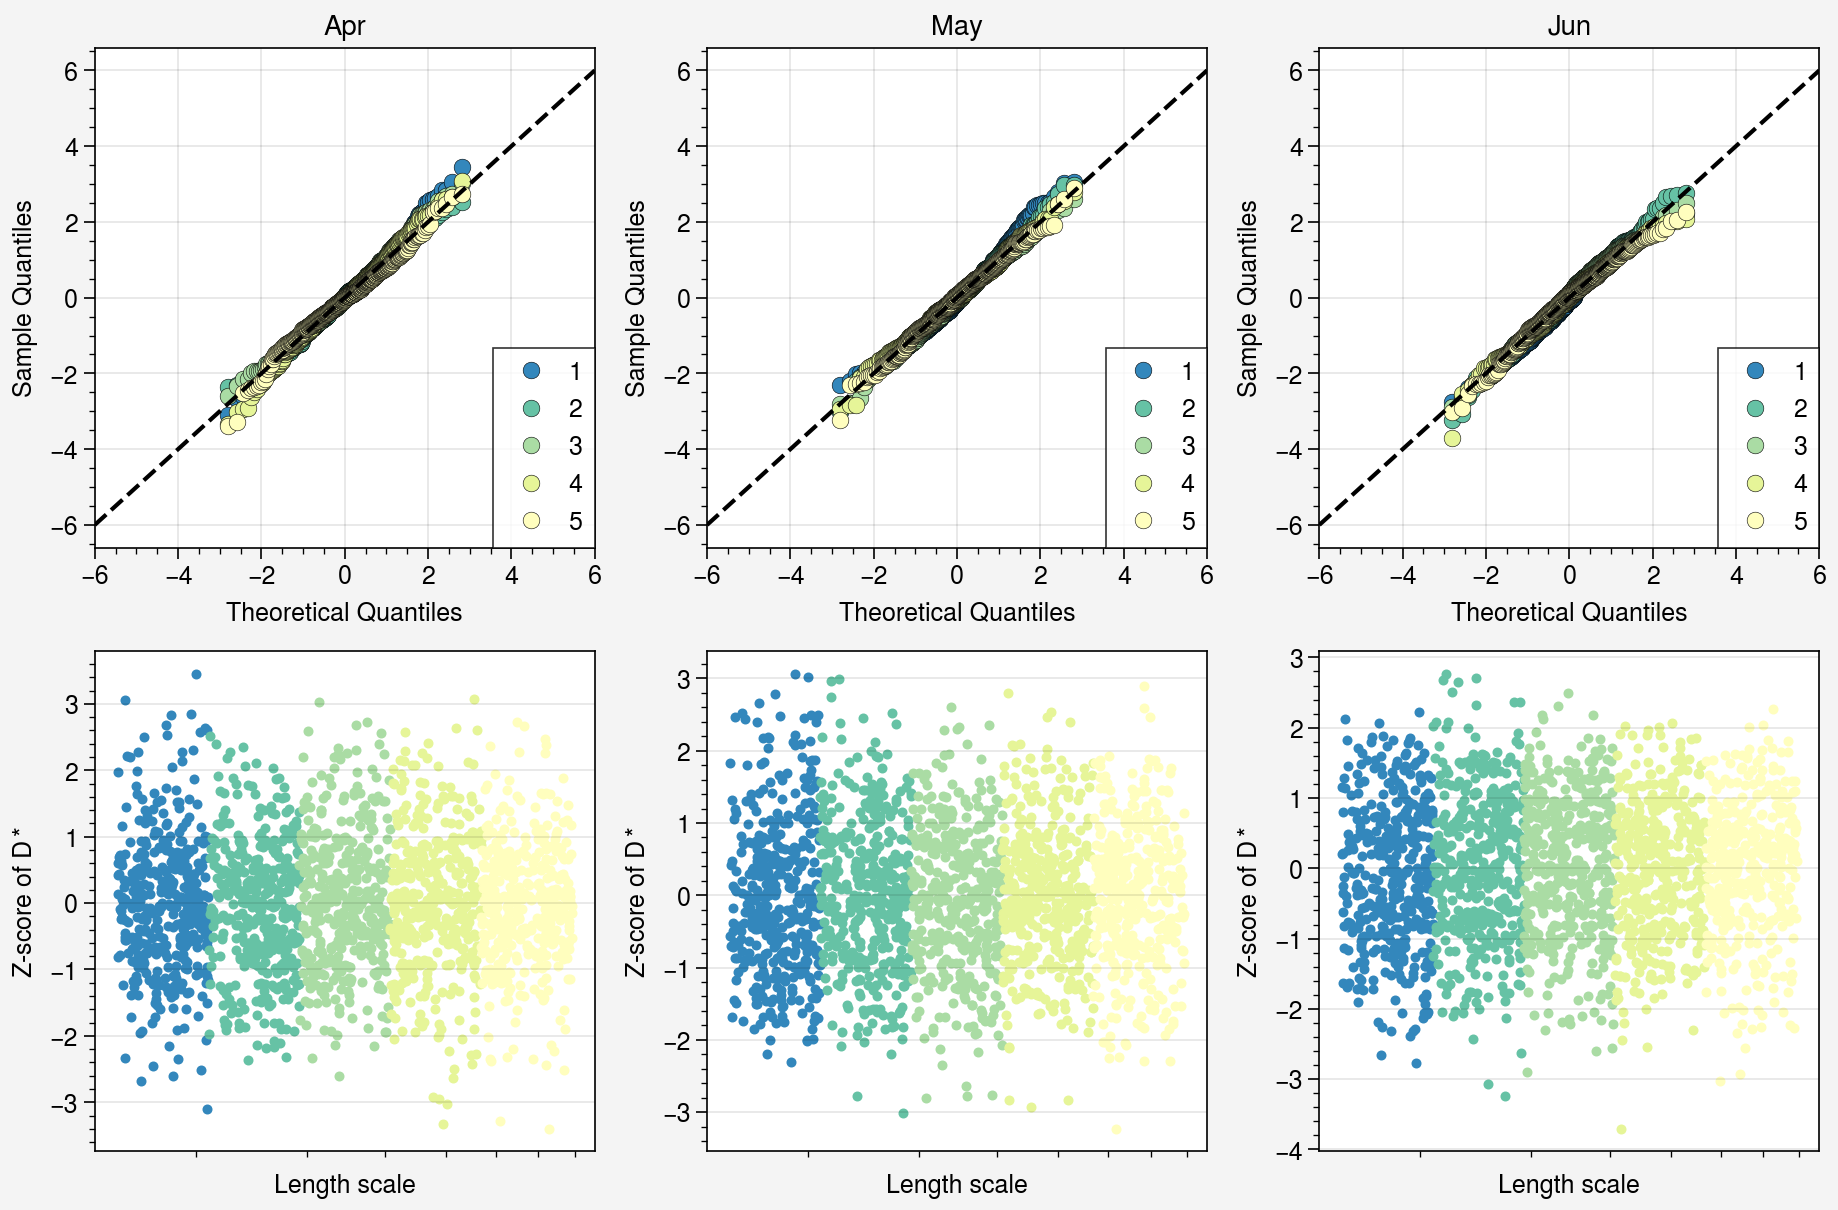

In [66]:
bincolors = {lb: color['color'] for lb, color in zip(np.arange(0, 11),
                                                pplt.Cycle('spectral_r',11))}
fig, axs = pplt.subplots(ncols=3, nrows=2, share=False)
for col, month, monthname in zip([0, 1, 2], [4, 5, 6], ['Apr', 'May', 'Jun']):
    strat_samp = samples[month].loc[samples[month].log_bin.between(1, 5)]
    beta_mle = bs_table.loc[month, 'beta_mle'] 
    data = np.log(strat_samp['total_deformation']*strat_samp['L']**beta_mle)
    data = pd.DataFrame({'Z': (data - np.mean(data))/np.std(data), 'L': strat_samp['L'], 'log_bin': strat_samp['log_bin']})
    
    
    axs[1, col].format(xscale='log', ylabel='Z-score of $D*$', xlabel='Length scale')
    
    for lbin, group in data.groupby('log_bin'):
        axs[1, col].scatter(group['L'].values, group['Z'].values, color=bincolors[lbin], marker='.')
        sm.qqplot(group['Z'], ax=axs[0, col], **{'marker': 'o', 'markerfacecolor': bincolors[lbin], 'markeredgecolor':'k', 'markeredgewidth': 0.2, 'label': lbin})
    axs[0, col].plot([-6, 6], [-6, 6], color='k', ls='--')
    axs[0, col].format(title=monthname)
    axs[0, col].legend(ncols=1, loc='lr')
fig.save('../figures/figS10_qqplot_comnparison.png', dpi=300)

Some notes based on plotting single groups at a time:
* Small scales seem identically distributed (log bins 1 and 2). Both have a tilted qq plot showing relatively more frequent low values and less frequent high values.
* Next, 3 and 4 are closer to the lognormal distribution for the higher values, but still have relatively more frequent low Z scores
* 5-7 have more frequent high values and less frequent low values, the qq plot is skewed the opposite way
* 

# TBD
* Compare the local fit to the global fit with alternative methods of fitting a lognormal distribution. Can we rule it out? Are we getting the best mu/std estimates?

Powerlaw distribution application to the data within a length scale bin

In [35]:
import powerlaw
data = samples[5].copy()

400
400
400
400


Calculating best minimal value for power law fit
/opt/homebrew/Caskroom/miniconda/base/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/homebrew/Caskroom/miniconda/base/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/homebrew/Caskroom/miniconda/base/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/homebrew/Caskroom/miniconda/base/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
/opt/homebrew/Caskroom/miniconda/base/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/homebrew/Caskroom/miniconda/base/envs/ift_annals/lib

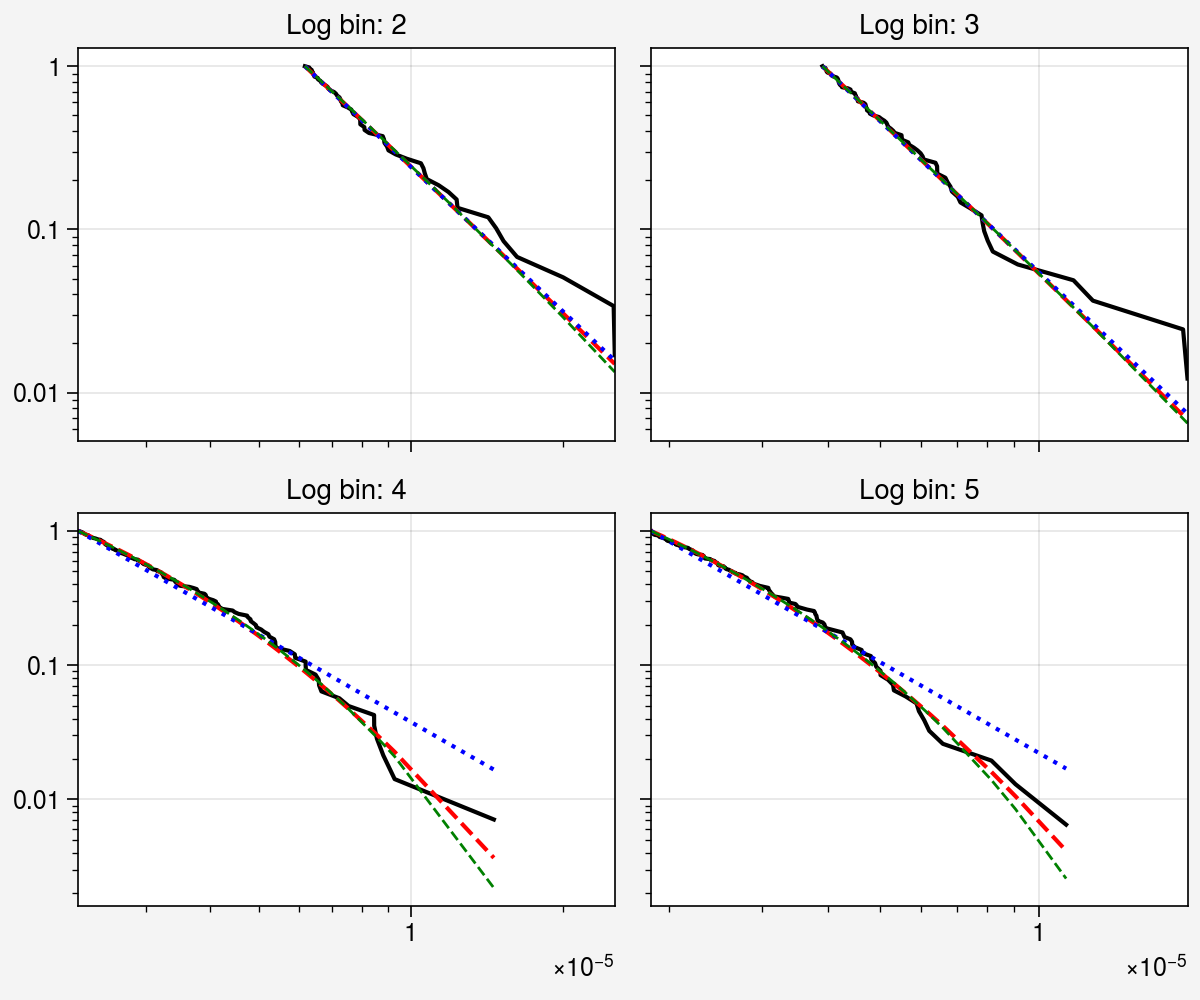

In [63]:
fig, axs = pplt.subplots(width=6, height=5, nrows=2, ncols=2)
for ax, log_bin in zip(axs, range(2, 6)):
    print(len(data.loc[data.log_bin == log_bin]))
    fit = powerlaw.Fit(data.loc[data.log_bin == log_bin, 'total_deformation'])

    fit.plot_ccdf(ax=ax, color='k')
    fit.lognormal.plot_ccdf(ax=ax, ls='--', color='r')
    fit.power_law.plot_ccdf(ax=ax, ls=':', color='b')
    fit.truncated_power_law.plot_ccdf(color='green', ax=ax, linestyle='--', lw=1)
    ax.format(title='Log bin: ' + str(log_bin))



In [51]:
ccdf = black
lognormal = red
power law = blue
truncated power law = green

In [62]:
strat_samp.groupby('log_bin').count()

datetime  triangle_number  floe1  floe2  floe3   u1   u2   u3   v1  \
log_bin                                                                       
1             400              400    400    400    400  400  400  400  400   
2             400              400    400    400    400  400  400  400  400   
3             400              400    400    400    400  400  400  400  400   
4             400              400    400    400    400  400  400  400  400   
5             400              400    400    400    400  400  400  400  400   

          v2  ...  min_angle    L  divergence  vorticity  pure_shear  \
log_bin       ...                                                      
1        400  ...        400  400         400        400         400   
2        400  ...        400  400         400        400         400   
3        400  ...        400  400         400        400         400   
4        400  ...        400  400         400        400         400   
5        400  ...        400  400         400        400         400   

         normal_shear  maximum_shear_strain_rate  total_deformation  \
log_bin                                                               
1                 400                        400                400   
2                 400                        400                400   
3                 400                        400                400   
4                 400                        400                400   
5                 400                        400                400   

         no_overlap_sample  month  
log_bin                            
1                      400    400  
2                      400    400  
3                      400    400  
4                      400    400  
5                      400    400  

[5 rows x 40 columns]

In [42]:
fit.lognormal.sigma

0.7677524021109832

Calculating best minimal value for power law fit
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/opt/miniconda3/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


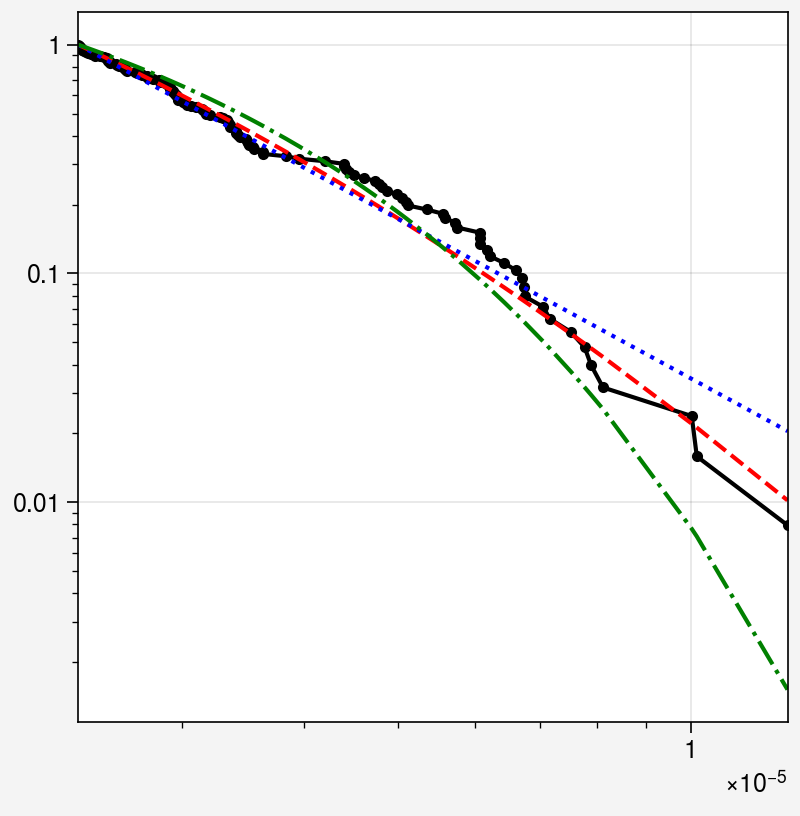

In [108]:
fig, ax = pplt.subplots(width=4)
log_bin = 3
for year in range(2003, 2004):
    d = data.loc[(data.log_bin == log_bin), 'total_deformation']
    fit = powerlaw.Fit(np.abs(d))
    fit.plot_ccdf(ax=ax, color='k', marker='.')
    fit.lognormal.plot_ccdf(ax=ax, ls='--', color='r')
    fit.power_law.plot_ccdf(ax=ax, ls=':', color='b')
    fit.exponential.plot_ccdf(ax=ax, ls='-.', color='g')
# fit.exponential.plot_ccdf(ax=ax)

In [64]:
print(fit.distribution_compare('power_law', 'truncated_power_law', nested=True))
print(fit.distribution_compare('power_law', 'lognormal', nested=True))
print(fit.distribution_compare('power_law', 'exponential', nested=True))
print(fit.distribution_compare('lognormal', 'exponential', nested=True))
print(fit.distribution_compare('lognormal', 'truncated_power_law', nested=True))

(-3.5523909466166836, 0.007687857891635286)
(-3.1346628291513268, 0.01228458872954874)
(-1.9709063969098297, 0.04709999623234751)
(1.163756432241497, 0.1271048157739103)
(-0.4177281174653569, 0.3606995318373105)


Assuming nested distributions
/opt/homebrew/Caskroom/miniconda/base/envs/ift_annals/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


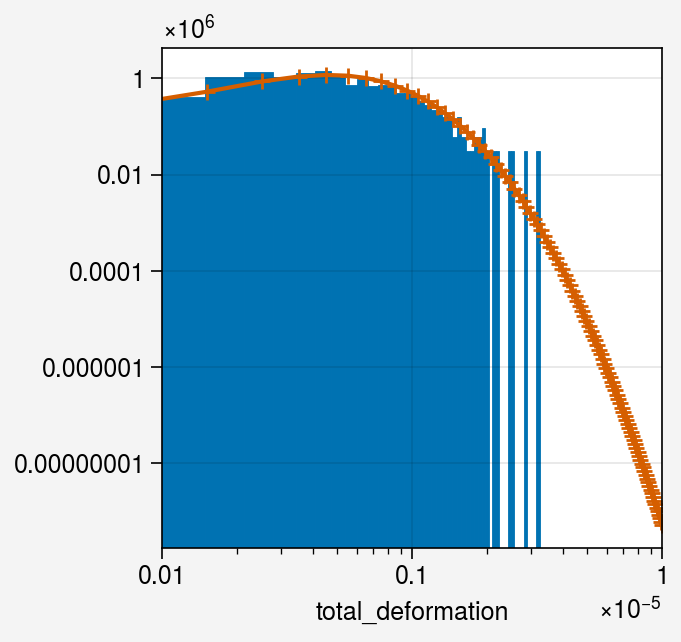

In [141]:
import scipy.stats as stats
fig, ax = pplt.subplots()
log_bin = 7
x = np.abs(data.loc[data.log_bin == log_bin, 'total_deformation'])
ax.hist(x, bins=50, density=True)
shape, location, scale = stats.lognorm.fit(x)
ax.plot(np.linspace(0.5e-7, 1e-5, 100), stats.lognorm.pdf(np.linspace(1e-8, 1e-5, 100), shape, location, scale), marker='+')
ax.format(yscale='log', xscale='log', xlim=(1e-7, 1e-5))

In [519]:
fit.lognormal.mu, fit.lognormal.sigma

(-15.567266079668826, 0.997892889227757)

-2.895422811760541e-07

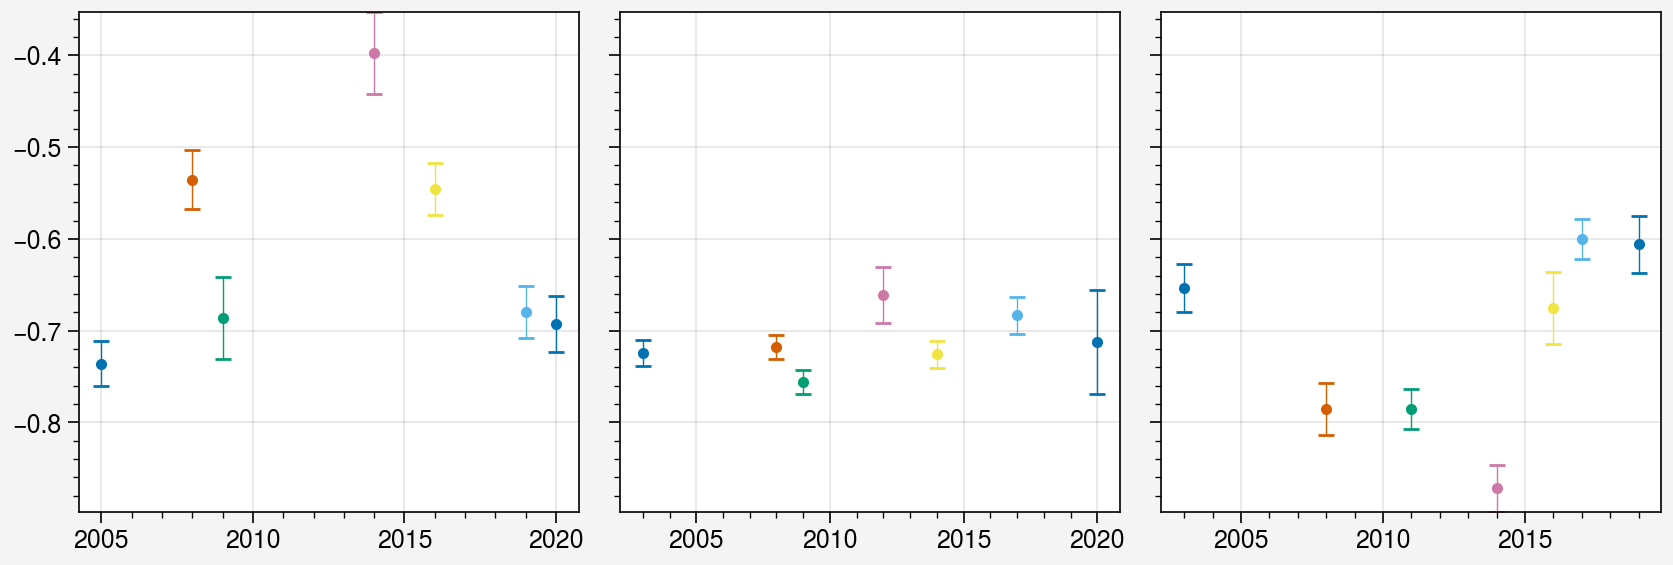

In [188]:
fig, axs = pplt.subplots(ncols=3)
for ax, month in zip(axs, range(4, 7)):
    for year in range(2003, 2021):
        data = all_results.loc[(all_results.datetime.dt.month == month) & (all_results.sampled)]
        data = data.loc[(data.datetime.dt.year == year)]
        data = data.loc[(data.log_bin > 0) & (data.log_bin < 10)]
        
        data_mean = data.loc[data.sampled,['L', 'total_deformation', 'log_bin']].groupby('log_bin').mean()
        data_std = data.loc[data.sampled,['L', 'total_deformation', 'log_bin']].groupby('log_bin').std()
        n = data.loc[data.sampled,['L', 'total_deformation', 'log_bin']].groupby('log_bin').count()
        data_mean = data_mean.where(n['total_deformation'] > 50).dropna()
        data_std = data_std.where(n['total_deformation'] > 50).dropna()
        if len(data_mean) > 6:
            beta, a, r, p, err = linregress(np.log10(data_mean['L']), np.log10(data_mean['total_deformation']*24*60*60))
            
            ax.errorbar([year], [beta], lw=0.5, yerr=[err], marker='.')

In [190]:
strat_samp

datetime  triangle_number       floe1       floe2  \
2303593 2017-06-27 12:00:00              100  2017_06605  2017_06706   
547517  2004-06-06 12:00:00              145  2004_00866  2004_00917   
542489  2003-06-24 12:00:00               42  2003_06749  2003_07653   
1124256 2011-06-18 12:00:00              997  2011_01767  2011_02176   
541978  2003-06-22 12:00:00              249  2003_07110  2003_07636   
...                     ...              ...         ...         ...   
1578283 2014-06-12 12:00:00            11138  2014_05841  2014_06058   
2637846 2019-06-14 12:00:00             8175  2019_04314  2019_04715   
1118480 2011-06-17 12:00:00              185  2011_01710  2011_01751   
1138043 2011-06-24 12:00:00             3165  2011_02529  2011_02589   
1558722 2014-06-11 12:00:00             5061  2014_05636  2014_05905   

              floe3       u1       u2       u3       v1       v2  ...  \
2303593  2017_06733 -0.06240 -0.02376 -0.03128 -0.12313 -0.06000  ...   
547517   2004_00871 -0.03536  0.01340  0.01526  0.05819  0.04256  ...   
542489   2003_07616  0.06358  0.00745  0.00706 -0.00163  0.02466  ...   
1124256  2011_01960 -0.04058 -0.10172 -0.00280 -0.12094 -0.04234  ...   
541978   2003_07497  0.06898  0.05047  0.04365  0.09849  0.06193  ...   
...             ...      ...      ...      ...      ...      ...  ...   
1578283  2014_06123  0.00729 -0.04126  0.19339 -0.01203 -0.22351  ...   
2637846  2019_05029  0.00437 -0.02720 -0.04884 -0.12465 -0.07141  ...   
1118480  2011_02068 -0.06165 -0.06996 -0.02118 -0.03260 -0.07277  ...   
1138043  2011_02612  0.13012  0.08335 -0.05788 -0.12784  0.04756  ...   
1558722  2014_05844  0.01890  0.02596 -0.03100 -0.09551 -0.09720  ...   

                   y2             x3            y3    divergence  \
2303593 -1.243667e+06  800228.990369 -1.233436e+06  1.575616e-08   
547517  -1.340278e+06  746372.657482 -1.283294e+06  7.226381e-07   
542489  -1.071340e+06  628648.973907 -1.102096e+06  3.162246e-06   
1124256 -1.170586e+06  811361.642999 -1.141728e+06 -2.394742e-06   
541978  -1.053084e+06  799213.953758 -1.091175e+06  1.270399e-06   
...               ...            ...           ...           ...   
1578283 -1.407251e+06  851885.810955 -1.060820e+06  1.442573e-06   
2637846 -1.029972e+06  865034.034307 -7.423103e+05  9.283271e-08   
1118480 -1.043212e+06  719132.743611 -1.310161e+06 -4.863743e-07   
1138043 -1.237000e+06  800729.016800 -9.981294e+05 -2.206344e-06   
1558722 -6.601916e+05  757536.752291 -1.070571e+06 -4.033493e-07   

            vorticity    pure_shear  normal_shear  total_deformation  month  \
2303593 -7.786873e-06 -9.571678e-06  1.351285e-07       4.786316e-06      6   
547517  -6.423151e-06 -5.815069e-06  6.353551e-06       4.306467e-06      6   
542489  -1.809615e-06 -1.476308e-06  2.666603e-06       1.523996e-06      6   
1124256 -2.007667e-07  5.726732e-06 -1.710362e-06       2.988344e-06      6   
541978   1.275129e-06  2.422696e-06  1.255816e-07       1.212974e-06      6   
...               ...           ...           ...                ...    ...   
1578283 -1.702346e-06 -7.513553e-07  7.152059e-07       5.186652e-07      6   
2637846  1.485180e-06  1.354768e-06 -8.380519e-07       7.965122e-07      6   
1118480 -2.089590e-07 -2.928452e-07 -2.621101e-07       1.965070e-07      6   
1138043  3.589641e-07  3.881320e-07 -1.498049e-06       7.737567e-07      6   
1558722 -4.415923e-07 -7.877753e-08  5.565320e-07       2.810399e-07      6   

         year  
2303593  2017  
547517   2004  
542489   2003  
1124256  2011  
541978   2003  
...       ...  
1578283  2014  
2637846  2019  
1118480  2011  
1138043  2011  
1558722  2014  

[7000 rows x 47 columns]

In [16]:
df_100km.columns

Index(['datetime', 'triangle_number', 'floe1', 'floe2', 'floe3', 'u1', 'u2',
       'u3', 'v1', 'v2', 'v3', 'lat1', 'lat2', 'lat3', 'lon1', 'lon2', 'lon3',
       'area', 'min_angle', 'L', 'log_bin', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3',
       'divergence', 'vorticity', 'pure_shear', 'normal_shear',
       'total_deformation', 'month', 'year'],
      dtype='object')

In [19]:
df_ift = pd.read_csv('../data/floe_tracker/ift_with_era5.csv')

In [21]:
# Silly mistake - each floe has multiple distances.
# Need to index both by date and by floe.
# edge_dist = df_ift.loc[:, ['floe_id', 'edge_dist']].set_index('floe_id')


In [ ]:
import pandas as pd
df = pd.read_csv('../data/deformation/ift_deformation_calculations_2003.csv')

In [40]:
df = df.dropna(subset='divergence')

logbins = np.logspace(np.log(10), np.log(300), base=np.e, num=10)
df['L'] = np.sqrt(df['area_km2'])
df['log_bin'] = np.digitize(df['L'], logbins)


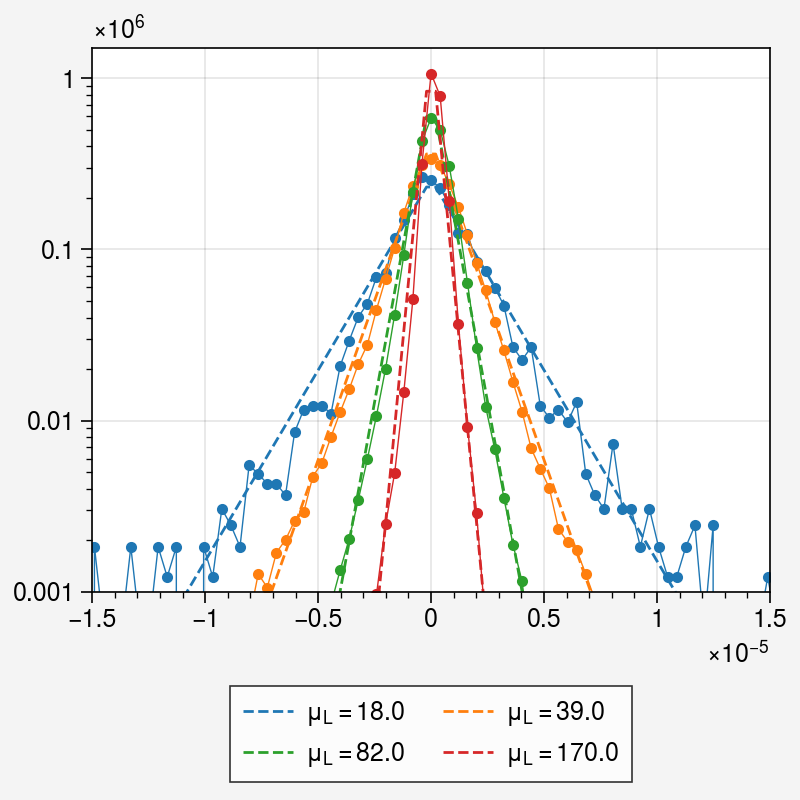

In [78]:
import scipy.stats as stats
var = 'divergence'
colors = pplt.Cycle('tab10', 8)
fig, ax = pplt.subplots(width=4, height=4)
for log_bin, c in zip(range(2, 10, 2), [x['color'] for x in colors]):
    ls = '--'
    if len(df.loc[df.log_bin==log_bin].dropna(subset=var)) > 500:
        
        train = df.loc[df.log_bin==log_bin].dropna(subset=var).sample(500, replace=False)
        # train[[var]] = train[[var]] / train[['length_bin', var]].groupby('length_bin').transform(lambda x: x.std())
        test =  df.loc[df.log_bin==log_bin].dropna(subset=var)
        test = test.loc[[x for x in test.index if x not in train.index], :]
        loc, scale = stats.expon.fit(np.abs(train[var]), floc=0)

        pdf, x_bins = np.histogram(test[var], bins=np.linspace(-3e-5, 3e-5, 150), density=True)
        x_center = 1/2*(x_bins[1:] + x_bins[:-1])
        
        ax.plot(x_center, pdf, color=c, label='', marker='.', lw=0.5)
        
        x = np.linspace(-2e-5, 2e-5, 100)
        ax.plot(x, 0.5*stats.expon(loc=loc, scale=scale).pdf(np.abs(x)), ls=ls, c=c, lw=1,
                label='$\mu_L =$' + str(np.round(test['L'].mean())))
        ax.format(yscale='log', ylim=(1e3, 1.5e6), xlim=(-1.5e-5, 1.5e-5))
ax.legend(loc='b', ncols=2)

colors = pplt.Cycle('tab10', 10)
